In [15]:
import sys
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [2]:
# Constants
LOCAL_LOCATION_X = "../Data/fpkm_normalized.csv"
LOCAL_LOCATION_Y = "../Data/optimal_encoded_scae_dropout.csv"
DAMAVAND_LOCATION_X = "~/f/Behrooz/dataset_local/fpkm_normalized.csv"
DAMAVAND_LOCATION_Y = "~/f/Behrooz/dataset_local/optimal_encoded_scae_dropout.csv"

# Hyper-Parameters
LEARNING_RATE = 1e-3
DROP_OUT = 0.5
N_SAMPLES = 10787
N_FEATURES = 19671
N_DISEASES = 34
N_BATCHES = 2000
N_EPOCHS = 100
N_BATCH_LEARN = 10

In [3]:
def weight_initializer(shape, stddev=0.01, name=None):
    initial = tf.random_normal(shape=shape, stddev=stddev)
    return tf.Variable(initial, name=name)


def bias_initializer(shape, init_value=0.1, name=None):
    initial = tf.constant(init_value, shape=shape)
    return tf.Variable(initial, name=name)


def load_data(filename):  # TODO search for faster way to load data
    return pd.read_csv(filename, header=None)


def fully_connected(input_data, weight, bias, name=None):
    return tf.nn.relu(tf.add(tf.matmul(input_data, weight), bias, name=name))


def drop_out(prev_output, keep_prob):
    return tf.nn.dropout(prev_output, keep_prob)



In [24]:
def train(x_data, y_data, steps=5000, batch_size=20, num_epochs=10000):
    # Split data into train/test = 80%/20%
    X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.20)
    print(X_train.shape)

    # training_size = X_train.shape[0]

    # Create Network and Variables
    with tf.Graph().as_default():
        feature_columns = [tf.feature_column.numeric_column('x', shape=X_train.shape[1:])]
        regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_columns,
                                                  activation_fn=tf.nn.relu, hidden_units=[1024, 256, 64])

        def input_fn(x, y=None):
            if y is not None:  # Training
                features = {k: tf.constant(x[k].values) for k in x.columns}
                responses = tf.constant(y.values, shape=y.shape)
                return features, responses
            else:  # Testing
                features = {k: tf.constant(x[k].values) for k in x_data.columns}
                return features

        # Training...
        train_input_fn = tf.estimator.inputs.numpy_input_fn(
            x={'x': X_train.values}, y=Y_train.values, batch_size=batch_size, num_epochs=num_epochs, shuffle=True)
        print("Training...")
        regressor.fit(input_fn=train_input_fn, steps=steps)

        print("Testing...")
        test_input_fn = tf.estimator.inputs.numpy_input_fn(
            x={'x': X_test.values}, y=Y_test.values, num_epochs=1, shuffle=False)
        predictions = regressor.predict_scores(input_fn=test_input_fn)

        predictions = [p for p in predictions]
#         print(predictions)
#         print(len(predictions))
        y_predicted = np.array(predictions)
        y_predicted = y_predicted.reshape(np.array(Y_test).shape)

        # Score with sklearn
        score_sklearn = metrics.mean_squared_error(Y_test, y_predicted)
        print('MSE (sklearn): {0:f}'.format(score_sklearn))

        # Score with tensorflow
        scores = regressor.evaluate(input_fn=test_input_fn)
        print('MSE (tensorflow): {0:f}'.format(scores['loss']))
        
#         matplotlib.rc('xtick', labelsize=30) 
#         matplotlib.rc('ytick', labelsize=30) 

#         fig, ax = plt.subplots(figsize=(50, 40))

#         plt.style.use('ggplot')
        plt.plot(predictions, Y_test, 'ro')
        plt.xlabel('Predictions')
        plt.ylabel('Y_test')
        plt.title('Predictions vs. Y_test')
#         ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
        plt.show()
        
        

        # regressor.fit(input_fn=lambda: input_fn(X_train, Y_train), steps=100)
        # evaluation = regressor.evaluate(input_fn=lambda: input_fn(X_test), steps=1)
        # loss_score = evaluation["loss"]
        # print("Final Loss on the testing set: {0:f}".format(loss_score))
        # y = regressor.predict(input_fn=lambda: input_fn(X_test))

In [8]:
def model_2(x_data, y_data, n_features=50, n_diseases=1, n_epochs=250, n_batches=1000, n_batch_learn=10):
    X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.20)
    training_size = X_train.shape[0]

    with tf.Graph().as_default():
        x = tf.placeholder(tf.float32, shape=[None, n_features])
        y = tf.placeholder(tf.float32, shape=[None, n_diseases])
        keep_prob = tf.placeholder(tf.float32)
        neurons = {  # TODO train This new architecture
            'in': n_features,
            'l1': 1024,
            'l2': 256,
            'l3': 64,
            'out': n_diseases
        }
        weights = {
            'l1': weight_initializer(shape=[neurons['in'], neurons['l1']], stddev=0.1, name='w1'),
            'l2': weight_initializer(shape=[neurons['l1'], neurons['l2']], stddev=0.1, name='w2'),
            'l3': weight_initializer(shape=[neurons['l2'], neurons['l3']], stddev=0.1, name='w3'),
            'out': weight_initializer(shape=[neurons['l3'], neurons['out']], stddev=0.1, name='w_out')
        }

        biases = {
            'l1': bias_initializer(init_value=0.1, shape=[neurons['l1']], name='b1'),
            'l2': bias_initializer(init_value=0.1, shape=[neurons['l2']], name='b2'),
            'l3': bias_initializer(init_value=0.1, shape=[neurons['l3']], name='b3'),
            'out': bias_initializer(init_value=0.1, shape=[neurons['out']], name='b_out')
        }
        # 1st Layer --> Fully Connected (1024 Neurons)
        layer_1 = fully_connected(x, weights['l1'], biases['l1'], name='l1')
        layer_1 = drop_out(layer_1, keep_prob)

        # 2nd Layer --> Fully Connected (256 Neurons)
        layer_2 = fully_connected(layer_1, weights['l2'], biases['l2'], name='l2')
        layer_2 = drop_out(layer_2, keep_prob)

        # 3rd Layer --> Fully Connected (64 Neurons)
        layer_3 = fully_connected(layer_2, weights['l3'], biases['l3'], name='l3')
        layer_3 = drop_out(layer_3, keep_prob)

        # Final Layer --> Fully Connected (N_DISEASES Neurons)
        final_output = fully_connected(layer_3, weights['out'], biases['out'], name='l_out')

        loss = tf.reduce_mean(tf.square(final_output - y),name='loss')
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001, name='optimizer')
        train_step = optimizer.minimize(loss, name='train_step')

        init = tf.global_variables_initializer()

        training_acc = []
        validation_acc = []
        training_loss = []
        validation_loss = []

        with tf.Session() as sess:
            sess.run(init)
            
            for epoch in range(n_epochs):
                # Train Network
                for i in range(n_batch_learn):
                    batch_indices = np.random.choice(training_size, size=n_batches)
                    x_train_batch = X_train.iloc[batch_indices]
                    y_train_batch = Y_train.iloc[batch_indices]

                    feed_dict = {x: x_train_batch, y: y_train_batch, keep_prob: DROP_OUT}
                    _, train_loss = sess.run([train_step, loss], feed_dict=feed_dict)
                    training_loss.append(train_loss)
                    prediction = tf.nn.softmax(final_output)
                    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_train_batch, 1))
                    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
                    feed_dict = {x: x_train_batch, y: y_train_batch, keep_prob: 1.0}
                    training_acc.append(accuracy.eval(feed_dict))

                    # Test Validation set
                    feed_dict = {x: X_test, y: Y_test, keep_prob: 1.0}
                    validation_loss.append(sess.run(loss, feed_dict=feed_dict))
                    prediction = tf.nn.softmax(final_output)
                    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y_test, 1))
                    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
                    validation_acc.append(accuracy.eval(feed_dict))
#                 if epoch % 5 == 0:
                print("Epoch:", '%04d' % (epoch + 1) if epoch == 0 else epoch,
#                       "\tValidation Accuracy =", '%01.9f' % (validation_acc[-1]),
                      "\tValidation Loss =", '%09.5f' % (validation_loss[-1]),
#                       "\tTraining Accuracy =", '%01.9f' % (training_acc[-1]),
                      "\tTraining Loss =", '%09.5f' % (training_loss[-1]))
            
        print("Training Finished!")


In [27]:
random_features = np.random.choice(19671, 50, replace=False)
print(np.array(random_features))
print("\nLoding Data...")
# x_data = pd.DataFrame([[i for i in range(50)] for _ in range(100)])
# y_data = pd.DataFrame([[i] for i in range(100)])
x_data, y_data = load_data(LOCAL_LOCATION_X)[random_features], load_data(LOCAL_LOCATION_Y)
print(y_data.shape)
print("Train Deep Neural Networks")

[10416  1253 12172 18457  1193  4076 18286  7026  2939  8051  1878  5240
  7760   295 13395 13618  9374  7427 16465 18248 17150 15318 14075  8294
  4036 18563  9242 11744  6817  2701 19039 17375   357 10847 13632   230
 18668 18774  1300 11638  7263   356 10048 15610  7405  4956 17063 12031
 16935  1222]

Loding Data...
(10787, 12)
Train Deep Neural Networks


(8629, 50)
Training...
Testing...
MSE (sklearn): 0.083383
MSE (tensorflow): 0.083500


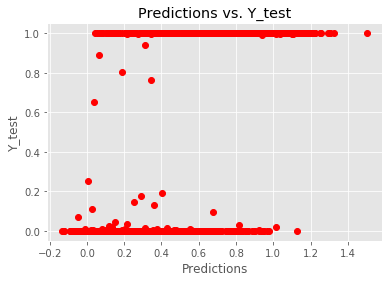

(8629, 50)
Training...
Testing...
MSE (sklearn): 0.072538
MSE (tensorflow): 0.072466


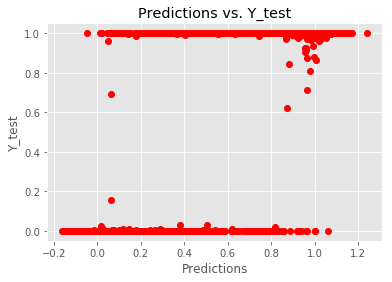

(8629, 50)
Training...
Testing...
MSE (sklearn): 0.070921
MSE (tensorflow): 0.070872


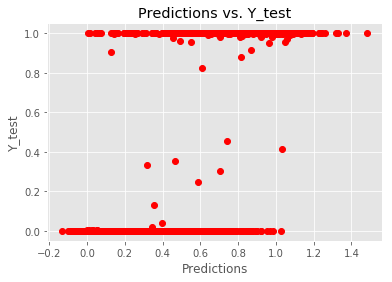

(8629, 50)
Training...
Testing...
MSE (sklearn): 0.072021
MSE (tensorflow): 0.072028


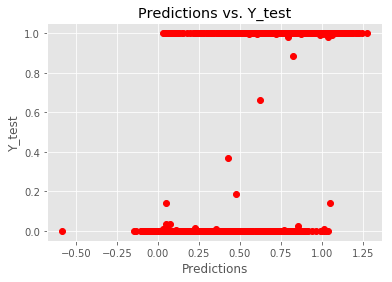

(8629, 50)
Training...
Testing...
MSE (sklearn): 0.080036
MSE (tensorflow): 0.080125


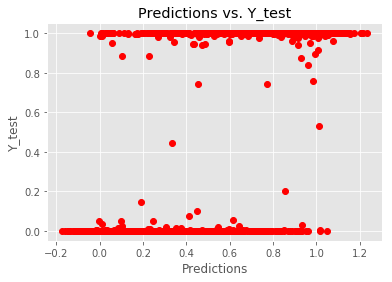

(8629, 50)
Training...
Testing...
MSE (sklearn): 0.065789
MSE (tensorflow): 0.065968


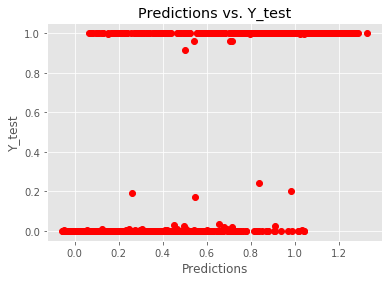

(8629, 50)
Training...
Testing...
MSE (sklearn): 0.108514
MSE (tensorflow): 0.108486


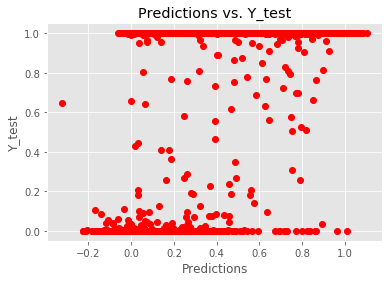

(8629, 50)
Training...
Testing...
MSE (sklearn): 0.089738
MSE (tensorflow): 0.089660


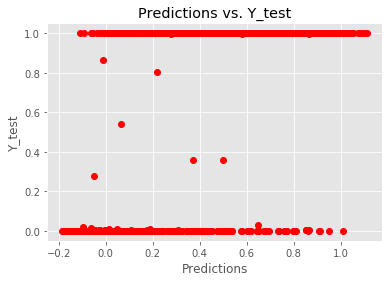

(8629, 50)
Training...
Testing...
MSE (sklearn): 0.081117
MSE (tensorflow): 0.081236


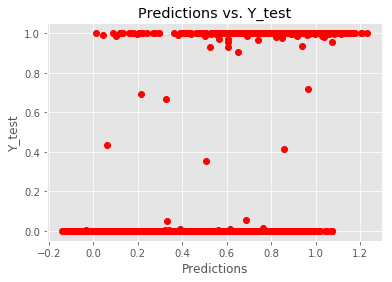

(8629, 50)
Training...
Testing...
MSE (sklearn): 0.071569
MSE (tensorflow): 0.071555


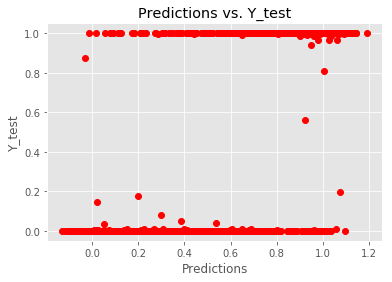

(8629, 50)
Training...
Testing...
MSE (sklearn): 0.075245
MSE (tensorflow): 0.075163


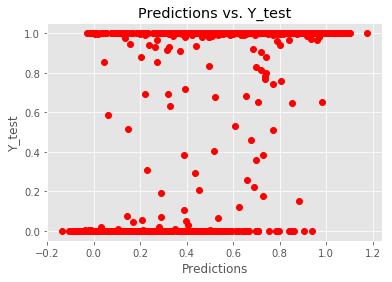

(8629, 50)
Training...
Testing...
MSE (sklearn): 0.068145
MSE (tensorflow): 0.068564


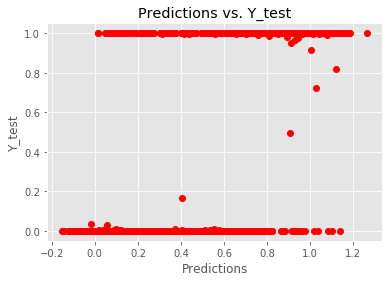

In [33]:
import warnings, os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)
for i in range(12):
    new_y = y_data[i]
    new_y = pd.DataFrame(np.reshape(new_y, newshape=[-1, 1]))
    train(x_data, new_y, num_epochs=5000, steps=5000, batch_size=128)

In [10]:
model_2(x_data, y_data, n_epochs=250, n_batches=2500, n_batch_learn=20)

Epoch: 0001 	Validation Loss = 000.28066 	Training Loss = 000.26405
Epoch: 1 	Validation Loss = 000.25627 	Training Loss = 000.23557
Epoch: 2 	Validation Loss = 000.21136 	Training Loss = 000.21376
Epoch: 3 	Validation Loss = 000.18766 	Training Loss = 000.20118
Epoch: 4 	Validation Loss = 000.17566 	Training Loss = 000.18608
Epoch: 5 	Validation Loss = 000.16118 	Training Loss = 000.18028
Epoch: 6 	Validation Loss = 000.15412 	Training Loss = 000.16506
Epoch: 7 	Validation Loss = 000.14694 	Training Loss = 000.16177
Epoch: 8 	Validation Loss = 000.14247 	Training Loss = 000.15610
Epoch: 9 	Validation Loss = 000.13005 	Training Loss = 000.14491
Epoch: 10 	Validation Loss = 000.12504 	Training Loss = 000.13181
Epoch: 11 	Validation Loss = 000.11665 	Training Loss = 000.12632
Epoch: 12 	Validation Loss = 000.10841 	Training Loss = 000.12443
Epoch: 13 	Validation Loss = 000.10206 	Training Loss = 000.11890
Epoch: 14 	Validation Loss = 000.09810 	Training Loss = 000.10446
Epoch: 15 	Valida

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/Future/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-4e4d1f40a266>", line 1, in <module>
    model_2(x_data, y_data, n_epochs=250, n_batches=2500, n_batch_learn=20)
  File "<ipython-input-8-07d1e5f4b1bc>", line 72, in model_2
    training_acc.append(accuracy.eval(feed_dict))
  File "/Users/Future/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 656, in eval
    return _eval_using_default_session(self, feed_dict, self.graph, session)
  File "/Users/Future/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 4905, in _eval_using_default_session
    return session.run(tensors, feed_dict)
  File "/Users/Future/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 905, in run
    run_metadata_ptr)
  File "/Users/Future/anaconda/lib/py

KeyboardInterrupt: 

In [14]:
train(x_data, y_data, num_epochs=5000, steps=50000, batch_size=50)

(8629, 50)
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1332bcc18>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/1p/w8nkt9fx1pd6_1hg0nvf4_yc0000gn/T/tmpsjs29u0y'}


INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1332bcc18>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/1p/w8nkt9fx1pd6_1hg0nvf4_yc0000gn/T/tmpsjs29u0y'}


Training...
INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 1 into /var/folders/1p/w8nkt9fx1pd6_1hg0nvf4_yc0000gn/T/tmpsjs29u0y/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1 into /var/folders/1p/w8nkt9fx1pd6_1hg0nvf4_yc0000gn/T/tmpsjs29u0y/model.ckpt.


INFO:tensorflow:loss = 0.44724163, step = 1


INFO:tensorflow:loss = 0.44724163, step = 1


INFO:tensorflow:global_step/sec: 236.879


INFO:tensorflow:global_step/sec: 236.879


INFO:tensorflow:loss = 0.2770371, step = 101 (0.425 sec)


INFO:tensorflow:loss = 0.2770371, step = 101 (0.425 sec)


INFO:tensorflow:global_step/sec: 273.599


INFO:tensorflow:global_step/sec: 273.599


INFO:tensorflow:loss = 0.23421429, step = 201 (0.364 sec)


INFO:tensorflow:loss = 0.23421429, step = 201 (0.364 sec)


INFO:tensorflow:global_step/sec: 250.275


INFO:tensorflow:global_step/sec: 250.275


INFO:tensorflow:loss = 0.19527298, step = 301 (0.401 sec)


INFO:tensorflow:loss = 0.19527298, step = 301 (0.401 sec)


INFO:tensorflow:global_step/sec: 246.179


INFO:tensorflow:global_step/sec: 246.179


INFO:tensorflow:loss = 0.16402134, step = 401 (0.408 sec)


INFO:tensorflow:loss = 0.16402134, step = 401 (0.408 sec)


INFO:tensorflow:global_step/sec: 240.303


INFO:tensorflow:global_step/sec: 240.303


INFO:tensorflow:loss = 0.15431729, step = 501 (0.416 sec)


INFO:tensorflow:loss = 0.15431729, step = 501 (0.416 sec)


INFO:tensorflow:global_step/sec: 230.664


INFO:tensorflow:global_step/sec: 230.664


INFO:tensorflow:loss = 0.13606282, step = 601 (0.434 sec)


INFO:tensorflow:loss = 0.13606282, step = 601 (0.434 sec)


INFO:tensorflow:global_step/sec: 232.184


INFO:tensorflow:global_step/sec: 232.184


INFO:tensorflow:loss = 0.1750627, step = 701 (0.430 sec)


INFO:tensorflow:loss = 0.1750627, step = 701 (0.430 sec)


INFO:tensorflow:global_step/sec: 229.831


INFO:tensorflow:global_step/sec: 229.831


INFO:tensorflow:loss = 0.1812631, step = 801 (0.435 sec)


INFO:tensorflow:loss = 0.1812631, step = 801 (0.435 sec)


INFO:tensorflow:global_step/sec: 224.13


INFO:tensorflow:global_step/sec: 224.13


INFO:tensorflow:loss = 0.16371906, step = 901 (0.446 sec)


INFO:tensorflow:loss = 0.16371906, step = 901 (0.446 sec)


INFO:tensorflow:global_step/sec: 221.108


INFO:tensorflow:global_step/sec: 221.108


INFO:tensorflow:loss = 0.1693676, step = 1001 (0.451 sec)


INFO:tensorflow:loss = 0.1693676, step = 1001 (0.451 sec)


INFO:tensorflow:global_step/sec: 223.016


INFO:tensorflow:global_step/sec: 223.016


INFO:tensorflow:loss = 0.11372615, step = 1101 (0.446 sec)


INFO:tensorflow:loss = 0.11372615, step = 1101 (0.446 sec)


INFO:tensorflow:global_step/sec: 220.043


INFO:tensorflow:global_step/sec: 220.043


INFO:tensorflow:loss = 0.14425004, step = 1201 (0.455 sec)


INFO:tensorflow:loss = 0.14425004, step = 1201 (0.455 sec)


INFO:tensorflow:global_step/sec: 218.924


INFO:tensorflow:global_step/sec: 218.924


INFO:tensorflow:loss = 0.13080317, step = 1301 (0.460 sec)


INFO:tensorflow:loss = 0.13080317, step = 1301 (0.460 sec)


INFO:tensorflow:global_step/sec: 207.315


INFO:tensorflow:global_step/sec: 207.315


INFO:tensorflow:loss = 0.1235152, step = 1401 (0.483 sec)


INFO:tensorflow:loss = 0.1235152, step = 1401 (0.483 sec)


INFO:tensorflow:global_step/sec: 217.575


INFO:tensorflow:global_step/sec: 217.575


INFO:tensorflow:loss = 0.15831134, step = 1501 (0.459 sec)


INFO:tensorflow:loss = 0.15831134, step = 1501 (0.459 sec)


INFO:tensorflow:global_step/sec: 210.865


INFO:tensorflow:global_step/sec: 210.865


INFO:tensorflow:loss = 0.12001319, step = 1601 (0.471 sec)


INFO:tensorflow:loss = 0.12001319, step = 1601 (0.471 sec)


INFO:tensorflow:global_step/sec: 210.275


INFO:tensorflow:global_step/sec: 210.275


INFO:tensorflow:loss = 0.13350843, step = 1701 (0.474 sec)


INFO:tensorflow:loss = 0.13350843, step = 1701 (0.474 sec)


INFO:tensorflow:global_step/sec: 203.118


INFO:tensorflow:global_step/sec: 203.118


INFO:tensorflow:loss = 0.13375017, step = 1801 (0.496 sec)


INFO:tensorflow:loss = 0.13375017, step = 1801 (0.496 sec)


INFO:tensorflow:global_step/sec: 209.749


INFO:tensorflow:global_step/sec: 209.749


INFO:tensorflow:loss = 0.14744712, step = 1901 (0.478 sec)


INFO:tensorflow:loss = 0.14744712, step = 1901 (0.478 sec)


INFO:tensorflow:global_step/sec: 214.406


INFO:tensorflow:global_step/sec: 214.406


INFO:tensorflow:loss = 0.08807445, step = 2001 (0.468 sec)


INFO:tensorflow:loss = 0.08807445, step = 2001 (0.468 sec)


INFO:tensorflow:global_step/sec: 216.882


INFO:tensorflow:global_step/sec: 216.882


INFO:tensorflow:loss = 0.09880478, step = 2101 (0.455 sec)


INFO:tensorflow:loss = 0.09880478, step = 2101 (0.455 sec)


INFO:tensorflow:global_step/sec: 215.794


INFO:tensorflow:global_step/sec: 215.794


INFO:tensorflow:loss = 0.20954677, step = 2201 (0.468 sec)


INFO:tensorflow:loss = 0.20954677, step = 2201 (0.468 sec)


INFO:tensorflow:global_step/sec: 215.543


INFO:tensorflow:global_step/sec: 215.543


INFO:tensorflow:loss = 0.10388624, step = 2301 (0.463 sec)


INFO:tensorflow:loss = 0.10388624, step = 2301 (0.463 sec)


INFO:tensorflow:global_step/sec: 226.914


INFO:tensorflow:global_step/sec: 226.914


INFO:tensorflow:loss = 0.09027134, step = 2401 (0.439 sec)


INFO:tensorflow:loss = 0.09027134, step = 2401 (0.439 sec)


INFO:tensorflow:global_step/sec: 226.58


INFO:tensorflow:global_step/sec: 226.58


INFO:tensorflow:loss = 0.12916651, step = 2501 (0.443 sec)


INFO:tensorflow:loss = 0.12916651, step = 2501 (0.443 sec)


INFO:tensorflow:global_step/sec: 215.062


INFO:tensorflow:global_step/sec: 215.062


INFO:tensorflow:loss = 0.11834291, step = 2601 (0.461 sec)


INFO:tensorflow:loss = 0.11834291, step = 2601 (0.461 sec)


INFO:tensorflow:global_step/sec: 234.507


INFO:tensorflow:global_step/sec: 234.507


INFO:tensorflow:loss = 0.0853129, step = 2701 (0.428 sec)


INFO:tensorflow:loss = 0.0853129, step = 2701 (0.428 sec)


INFO:tensorflow:global_step/sec: 225.471


INFO:tensorflow:global_step/sec: 225.471


INFO:tensorflow:loss = 0.11653263, step = 2801 (0.446 sec)


INFO:tensorflow:loss = 0.11653263, step = 2801 (0.446 sec)


INFO:tensorflow:global_step/sec: 223.58


INFO:tensorflow:global_step/sec: 223.58


INFO:tensorflow:loss = 0.18663377, step = 2901 (0.447 sec)


INFO:tensorflow:loss = 0.18663377, step = 2901 (0.447 sec)


INFO:tensorflow:global_step/sec: 220.85


INFO:tensorflow:global_step/sec: 220.85


INFO:tensorflow:loss = 0.115040824, step = 3001 (0.452 sec)


INFO:tensorflow:loss = 0.115040824, step = 3001 (0.452 sec)


INFO:tensorflow:global_step/sec: 231.329


INFO:tensorflow:global_step/sec: 231.329


INFO:tensorflow:loss = 0.079049975, step = 3101 (0.430 sec)


INFO:tensorflow:loss = 0.079049975, step = 3101 (0.430 sec)


INFO:tensorflow:global_step/sec: 224.333


INFO:tensorflow:global_step/sec: 224.333


INFO:tensorflow:loss = 0.09617073, step = 3201 (0.449 sec)


INFO:tensorflow:loss = 0.09617073, step = 3201 (0.449 sec)


INFO:tensorflow:global_step/sec: 216.751


INFO:tensorflow:global_step/sec: 216.751


INFO:tensorflow:loss = 0.10502514, step = 3301 (0.460 sec)


INFO:tensorflow:loss = 0.10502514, step = 3301 (0.460 sec)


INFO:tensorflow:global_step/sec: 227.861


INFO:tensorflow:global_step/sec: 227.861


INFO:tensorflow:loss = 0.08774117, step = 3401 (0.440 sec)


INFO:tensorflow:loss = 0.08774117, step = 3401 (0.440 sec)


INFO:tensorflow:global_step/sec: 211.194


INFO:tensorflow:global_step/sec: 211.194


INFO:tensorflow:loss = 0.118999995, step = 3501 (0.473 sec)


INFO:tensorflow:loss = 0.118999995, step = 3501 (0.473 sec)


INFO:tensorflow:global_step/sec: 223.372


INFO:tensorflow:global_step/sec: 223.372


INFO:tensorflow:loss = 0.07296651, step = 3601 (0.444 sec)


INFO:tensorflow:loss = 0.07296651, step = 3601 (0.444 sec)


INFO:tensorflow:global_step/sec: 204.133


INFO:tensorflow:global_step/sec: 204.133


INFO:tensorflow:loss = 0.104642175, step = 3701 (0.495 sec)


INFO:tensorflow:loss = 0.104642175, step = 3701 (0.495 sec)


INFO:tensorflow:global_step/sec: 210.912


INFO:tensorflow:global_step/sec: 210.912


INFO:tensorflow:loss = 0.069086336, step = 3801 (0.474 sec)


INFO:tensorflow:loss = 0.069086336, step = 3801 (0.474 sec)


INFO:tensorflow:global_step/sec: 206.816


INFO:tensorflow:global_step/sec: 206.816


INFO:tensorflow:loss = 0.071032435, step = 3901 (0.485 sec)


INFO:tensorflow:loss = 0.071032435, step = 3901 (0.485 sec)


INFO:tensorflow:global_step/sec: 195.625


INFO:tensorflow:global_step/sec: 195.625


INFO:tensorflow:loss = 0.040936213, step = 4001 (0.510 sec)


INFO:tensorflow:loss = 0.040936213, step = 4001 (0.510 sec)


INFO:tensorflow:global_step/sec: 208.9


INFO:tensorflow:global_step/sec: 208.9


INFO:tensorflow:loss = 0.07420322, step = 4101 (0.478 sec)


INFO:tensorflow:loss = 0.07420322, step = 4101 (0.478 sec)


INFO:tensorflow:global_step/sec: 210.725


INFO:tensorflow:global_step/sec: 210.725


INFO:tensorflow:loss = 0.08248942, step = 4201 (0.475 sec)


INFO:tensorflow:loss = 0.08248942, step = 4201 (0.475 sec)


INFO:tensorflow:global_step/sec: 215.476


INFO:tensorflow:global_step/sec: 215.476


INFO:tensorflow:loss = 0.064849235, step = 4301 (0.464 sec)


INFO:tensorflow:loss = 0.064849235, step = 4301 (0.464 sec)


INFO:tensorflow:global_step/sec: 205.339


INFO:tensorflow:global_step/sec: 205.339


INFO:tensorflow:loss = 0.07895224, step = 4401 (0.486 sec)


INFO:tensorflow:loss = 0.07895224, step = 4401 (0.486 sec)


INFO:tensorflow:global_step/sec: 208.188


INFO:tensorflow:global_step/sec: 208.188


INFO:tensorflow:loss = 0.030168917, step = 4501 (0.481 sec)


INFO:tensorflow:loss = 0.030168917, step = 4501 (0.481 sec)


INFO:tensorflow:global_step/sec: 199.908


INFO:tensorflow:global_step/sec: 199.908


INFO:tensorflow:loss = 0.083658524, step = 4601 (0.498 sec)


INFO:tensorflow:loss = 0.083658524, step = 4601 (0.498 sec)


INFO:tensorflow:global_step/sec: 209.218


INFO:tensorflow:global_step/sec: 209.218


INFO:tensorflow:loss = 0.09500123, step = 4701 (0.480 sec)


INFO:tensorflow:loss = 0.09500123, step = 4701 (0.480 sec)


INFO:tensorflow:global_step/sec: 206.32


INFO:tensorflow:global_step/sec: 206.32


INFO:tensorflow:loss = 0.0555962, step = 4801 (0.485 sec)


INFO:tensorflow:loss = 0.0555962, step = 4801 (0.485 sec)


INFO:tensorflow:global_step/sec: 198.824


INFO:tensorflow:global_step/sec: 198.824


INFO:tensorflow:loss = 0.07300582, step = 4901 (0.504 sec)


INFO:tensorflow:loss = 0.07300582, step = 4901 (0.504 sec)


INFO:tensorflow:global_step/sec: 204.184


INFO:tensorflow:global_step/sec: 204.184


INFO:tensorflow:loss = 0.07996829, step = 5001 (0.485 sec)


INFO:tensorflow:loss = 0.07996829, step = 5001 (0.485 sec)


INFO:tensorflow:global_step/sec: 216.789


INFO:tensorflow:global_step/sec: 216.789


INFO:tensorflow:loss = 0.06444852, step = 5101 (0.467 sec)


INFO:tensorflow:loss = 0.06444852, step = 5101 (0.467 sec)


INFO:tensorflow:global_step/sec: 208.635


INFO:tensorflow:global_step/sec: 208.635


INFO:tensorflow:loss = 0.03508933, step = 5201 (0.477 sec)


INFO:tensorflow:loss = 0.03508933, step = 5201 (0.477 sec)


INFO:tensorflow:global_step/sec: 207.107


INFO:tensorflow:global_step/sec: 207.107


INFO:tensorflow:loss = 0.052106325, step = 5301 (0.485 sec)


INFO:tensorflow:loss = 0.052106325, step = 5301 (0.485 sec)


INFO:tensorflow:global_step/sec: 205.65


INFO:tensorflow:global_step/sec: 205.65


INFO:tensorflow:loss = 0.08705162, step = 5401 (0.482 sec)


INFO:tensorflow:loss = 0.08705162, step = 5401 (0.482 sec)


INFO:tensorflow:global_step/sec: 201.472


INFO:tensorflow:global_step/sec: 201.472


INFO:tensorflow:loss = 0.063107274, step = 5501 (0.498 sec)


INFO:tensorflow:loss = 0.063107274, step = 5501 (0.498 sec)


INFO:tensorflow:global_step/sec: 207.379


INFO:tensorflow:global_step/sec: 207.379


INFO:tensorflow:loss = 0.08260158, step = 5601 (0.484 sec)


INFO:tensorflow:loss = 0.08260158, step = 5601 (0.484 sec)


INFO:tensorflow:global_step/sec: 214.467


INFO:tensorflow:global_step/sec: 214.467


INFO:tensorflow:loss = 0.06650447, step = 5701 (0.466 sec)


INFO:tensorflow:loss = 0.06650447, step = 5701 (0.466 sec)


INFO:tensorflow:global_step/sec: 205.776


INFO:tensorflow:global_step/sec: 205.776


INFO:tensorflow:loss = 0.04729458, step = 5801 (0.483 sec)


INFO:tensorflow:loss = 0.04729458, step = 5801 (0.483 sec)


INFO:tensorflow:global_step/sec: 208.33


INFO:tensorflow:global_step/sec: 208.33


INFO:tensorflow:loss = 0.083249286, step = 5901 (0.479 sec)


INFO:tensorflow:loss = 0.083249286, step = 5901 (0.479 sec)


INFO:tensorflow:global_step/sec: 226.712


INFO:tensorflow:global_step/sec: 226.712


INFO:tensorflow:loss = 0.12853423, step = 6001 (0.442 sec)


INFO:tensorflow:loss = 0.12853423, step = 6001 (0.442 sec)


INFO:tensorflow:global_step/sec: 223.269


INFO:tensorflow:global_step/sec: 223.269


INFO:tensorflow:loss = 0.058265563, step = 6101 (0.451 sec)


INFO:tensorflow:loss = 0.058265563, step = 6101 (0.451 sec)


INFO:tensorflow:global_step/sec: 218.236


INFO:tensorflow:global_step/sec: 218.236


INFO:tensorflow:loss = 0.08791027, step = 6201 (0.455 sec)


INFO:tensorflow:loss = 0.08791027, step = 6201 (0.455 sec)


INFO:tensorflow:global_step/sec: 213.768


INFO:tensorflow:global_step/sec: 213.768


INFO:tensorflow:loss = 0.060325336, step = 6301 (0.469 sec)


INFO:tensorflow:loss = 0.060325336, step = 6301 (0.469 sec)


INFO:tensorflow:global_step/sec: 221.199


INFO:tensorflow:global_step/sec: 221.199


INFO:tensorflow:loss = 0.06940236, step = 6401 (0.453 sec)


INFO:tensorflow:loss = 0.06940236, step = 6401 (0.453 sec)


INFO:tensorflow:global_step/sec: 217.436


INFO:tensorflow:global_step/sec: 217.436


INFO:tensorflow:loss = 0.0839946, step = 6501 (0.460 sec)


INFO:tensorflow:loss = 0.0839946, step = 6501 (0.460 sec)


INFO:tensorflow:global_step/sec: 219.487


INFO:tensorflow:global_step/sec: 219.487


INFO:tensorflow:loss = 0.058989476, step = 6601 (0.456 sec)


INFO:tensorflow:loss = 0.058989476, step = 6601 (0.456 sec)


INFO:tensorflow:global_step/sec: 225.714


INFO:tensorflow:global_step/sec: 225.714


INFO:tensorflow:loss = 0.088946246, step = 6701 (0.443 sec)


INFO:tensorflow:loss = 0.088946246, step = 6701 (0.443 sec)


INFO:tensorflow:global_step/sec: 232.405


INFO:tensorflow:global_step/sec: 232.405


INFO:tensorflow:loss = 0.04241112, step = 6801 (0.428 sec)


INFO:tensorflow:loss = 0.04241112, step = 6801 (0.428 sec)


INFO:tensorflow:global_step/sec: 229.747


INFO:tensorflow:global_step/sec: 229.747


INFO:tensorflow:loss = 0.056479994, step = 6901 (0.438 sec)


INFO:tensorflow:loss = 0.056479994, step = 6901 (0.438 sec)


INFO:tensorflow:global_step/sec: 221.911


INFO:tensorflow:global_step/sec: 221.911


INFO:tensorflow:loss = 0.057467837, step = 7001 (0.451 sec)


INFO:tensorflow:loss = 0.057467837, step = 7001 (0.451 sec)


INFO:tensorflow:global_step/sec: 220.95


INFO:tensorflow:global_step/sec: 220.95


INFO:tensorflow:loss = 0.076910794, step = 7101 (0.453 sec)


INFO:tensorflow:loss = 0.076910794, step = 7101 (0.453 sec)


INFO:tensorflow:global_step/sec: 211.379


INFO:tensorflow:global_step/sec: 211.379


INFO:tensorflow:loss = 0.08946723, step = 7201 (0.473 sec)


INFO:tensorflow:loss = 0.08946723, step = 7201 (0.473 sec)


INFO:tensorflow:global_step/sec: 218.945


INFO:tensorflow:global_step/sec: 218.945


INFO:tensorflow:loss = 0.04006507, step = 7301 (0.456 sec)


INFO:tensorflow:loss = 0.04006507, step = 7301 (0.456 sec)


INFO:tensorflow:global_step/sec: 216.794


INFO:tensorflow:global_step/sec: 216.794


INFO:tensorflow:loss = 0.05715187, step = 7401 (0.462 sec)


INFO:tensorflow:loss = 0.05715187, step = 7401 (0.462 sec)


INFO:tensorflow:global_step/sec: 216.016


INFO:tensorflow:global_step/sec: 216.016


INFO:tensorflow:loss = 0.044590797, step = 7501 (0.463 sec)


INFO:tensorflow:loss = 0.044590797, step = 7501 (0.463 sec)


INFO:tensorflow:global_step/sec: 204.584


INFO:tensorflow:global_step/sec: 204.584


INFO:tensorflow:loss = 0.06622793, step = 7601 (0.485 sec)


INFO:tensorflow:loss = 0.06622793, step = 7601 (0.485 sec)


INFO:tensorflow:global_step/sec: 212.014


INFO:tensorflow:global_step/sec: 212.014


INFO:tensorflow:loss = 0.025134359, step = 7701 (0.475 sec)


INFO:tensorflow:loss = 0.025134359, step = 7701 (0.475 sec)


INFO:tensorflow:global_step/sec: 211.796


INFO:tensorflow:global_step/sec: 211.796


INFO:tensorflow:loss = 0.058022827, step = 7801 (0.473 sec)


INFO:tensorflow:loss = 0.058022827, step = 7801 (0.473 sec)


INFO:tensorflow:global_step/sec: 198.654


INFO:tensorflow:global_step/sec: 198.654


INFO:tensorflow:loss = 0.025440294, step = 7901 (0.501 sec)


INFO:tensorflow:loss = 0.025440294, step = 7901 (0.501 sec)


INFO:tensorflow:global_step/sec: 199.537


INFO:tensorflow:global_step/sec: 199.537


INFO:tensorflow:loss = 0.03829457, step = 8001 (0.503 sec)


INFO:tensorflow:loss = 0.03829457, step = 8001 (0.503 sec)


INFO:tensorflow:global_step/sec: 201.877


INFO:tensorflow:global_step/sec: 201.877


INFO:tensorflow:loss = 0.065346956, step = 8101 (0.497 sec)


INFO:tensorflow:loss = 0.065346956, step = 8101 (0.497 sec)


INFO:tensorflow:global_step/sec: 209.512


INFO:tensorflow:global_step/sec: 209.512


INFO:tensorflow:loss = 0.080503866, step = 8201 (0.478 sec)


INFO:tensorflow:loss = 0.080503866, step = 8201 (0.478 sec)


INFO:tensorflow:global_step/sec: 205.813


INFO:tensorflow:global_step/sec: 205.813


INFO:tensorflow:loss = 0.01759262, step = 8301 (0.485 sec)


INFO:tensorflow:loss = 0.01759262, step = 8301 (0.485 sec)


INFO:tensorflow:global_step/sec: 203.05


INFO:tensorflow:global_step/sec: 203.05


INFO:tensorflow:loss = 0.099657275, step = 8401 (0.492 sec)


INFO:tensorflow:loss = 0.099657275, step = 8401 (0.492 sec)


INFO:tensorflow:global_step/sec: 206.029


INFO:tensorflow:global_step/sec: 206.029


INFO:tensorflow:loss = 0.06915737, step = 8501 (0.481 sec)


INFO:tensorflow:loss = 0.06915737, step = 8501 (0.481 sec)


INFO:tensorflow:global_step/sec: 212.448


INFO:tensorflow:global_step/sec: 212.448


INFO:tensorflow:loss = 0.016620481, step = 8601 (0.472 sec)


INFO:tensorflow:loss = 0.016620481, step = 8601 (0.472 sec)


INFO:tensorflow:global_step/sec: 208.976


INFO:tensorflow:global_step/sec: 208.976


INFO:tensorflow:loss = 0.06712444, step = 8701 (0.480 sec)


INFO:tensorflow:loss = 0.06712444, step = 8701 (0.480 sec)


INFO:tensorflow:global_step/sec: 214.347


INFO:tensorflow:global_step/sec: 214.347


INFO:tensorflow:loss = 0.045706734, step = 8801 (0.469 sec)


INFO:tensorflow:loss = 0.045706734, step = 8801 (0.469 sec)


INFO:tensorflow:global_step/sec: 204.659


INFO:tensorflow:global_step/sec: 204.659


INFO:tensorflow:loss = 0.10585057, step = 8901 (0.485 sec)


INFO:tensorflow:loss = 0.10585057, step = 8901 (0.485 sec)


INFO:tensorflow:global_step/sec: 208.817


INFO:tensorflow:global_step/sec: 208.817


INFO:tensorflow:loss = 0.03526697, step = 9001 (0.483 sec)


INFO:tensorflow:loss = 0.03526697, step = 9001 (0.483 sec)


INFO:tensorflow:global_step/sec: 187.79


INFO:tensorflow:global_step/sec: 187.79


INFO:tensorflow:loss = 0.048776962, step = 9101 (0.528 sec)


INFO:tensorflow:loss = 0.048776962, step = 9101 (0.528 sec)


INFO:tensorflow:global_step/sec: 213.355


INFO:tensorflow:global_step/sec: 213.355


INFO:tensorflow:loss = 0.049634088, step = 9201 (0.474 sec)


INFO:tensorflow:loss = 0.049634088, step = 9201 (0.474 sec)


INFO:tensorflow:global_step/sec: 208.127


INFO:tensorflow:global_step/sec: 208.127


INFO:tensorflow:loss = 0.067510515, step = 9301 (0.476 sec)


INFO:tensorflow:loss = 0.067510515, step = 9301 (0.476 sec)


INFO:tensorflow:global_step/sec: 215.205


INFO:tensorflow:global_step/sec: 215.205


INFO:tensorflow:loss = 0.047742147, step = 9401 (0.468 sec)


INFO:tensorflow:loss = 0.047742147, step = 9401 (0.468 sec)


INFO:tensorflow:global_step/sec: 205.276


INFO:tensorflow:global_step/sec: 205.276


INFO:tensorflow:loss = 0.054628182, step = 9501 (0.488 sec)


INFO:tensorflow:loss = 0.054628182, step = 9501 (0.488 sec)


INFO:tensorflow:global_step/sec: 201.345


INFO:tensorflow:global_step/sec: 201.345


INFO:tensorflow:loss = 0.035853196, step = 9601 (0.497 sec)


INFO:tensorflow:loss = 0.035853196, step = 9601 (0.497 sec)


INFO:tensorflow:global_step/sec: 205.619


INFO:tensorflow:global_step/sec: 205.619


INFO:tensorflow:loss = 0.09036664, step = 9701 (0.486 sec)


INFO:tensorflow:loss = 0.09036664, step = 9701 (0.486 sec)


INFO:tensorflow:global_step/sec: 201.711


INFO:tensorflow:global_step/sec: 201.711


INFO:tensorflow:loss = 0.045331687, step = 9801 (0.492 sec)


INFO:tensorflow:loss = 0.045331687, step = 9801 (0.492 sec)


INFO:tensorflow:global_step/sec: 197.434


INFO:tensorflow:global_step/sec: 197.434


INFO:tensorflow:loss = 0.030050382, step = 9901 (0.506 sec)


INFO:tensorflow:loss = 0.030050382, step = 9901 (0.506 sec)


INFO:tensorflow:global_step/sec: 204.145


INFO:tensorflow:global_step/sec: 204.145


INFO:tensorflow:loss = 0.05122326, step = 10001 (0.489 sec)


INFO:tensorflow:loss = 0.05122326, step = 10001 (0.489 sec)


INFO:tensorflow:global_step/sec: 201.159


INFO:tensorflow:global_step/sec: 201.159


INFO:tensorflow:loss = 0.033783097, step = 10101 (0.498 sec)


INFO:tensorflow:loss = 0.033783097, step = 10101 (0.498 sec)


INFO:tensorflow:global_step/sec: 204.679


INFO:tensorflow:global_step/sec: 204.679


INFO:tensorflow:loss = 0.06757786, step = 10201 (0.493 sec)


INFO:tensorflow:loss = 0.06757786, step = 10201 (0.493 sec)


INFO:tensorflow:global_step/sec: 211.372


INFO:tensorflow:global_step/sec: 211.372


INFO:tensorflow:loss = 0.0560498, step = 10301 (0.472 sec)


INFO:tensorflow:loss = 0.0560498, step = 10301 (0.472 sec)


INFO:tensorflow:global_step/sec: 213.885


INFO:tensorflow:global_step/sec: 213.885


INFO:tensorflow:loss = 0.04899652, step = 10401 (0.468 sec)


INFO:tensorflow:loss = 0.04899652, step = 10401 (0.468 sec)


INFO:tensorflow:global_step/sec: 213.077


INFO:tensorflow:global_step/sec: 213.077


INFO:tensorflow:loss = 0.050848503, step = 10501 (0.467 sec)


INFO:tensorflow:loss = 0.050848503, step = 10501 (0.467 sec)


INFO:tensorflow:global_step/sec: 216.826


INFO:tensorflow:global_step/sec: 216.826


INFO:tensorflow:loss = 0.043397155, step = 10601 (0.460 sec)


INFO:tensorflow:loss = 0.043397155, step = 10601 (0.460 sec)


INFO:tensorflow:global_step/sec: 210.864


INFO:tensorflow:global_step/sec: 210.864


INFO:tensorflow:loss = 0.03454294, step = 10701 (0.478 sec)


INFO:tensorflow:loss = 0.03454294, step = 10701 (0.478 sec)


INFO:tensorflow:global_step/sec: 179.232


INFO:tensorflow:global_step/sec: 179.232


INFO:tensorflow:loss = 0.036360543, step = 10801 (0.557 sec)


INFO:tensorflow:loss = 0.036360543, step = 10801 (0.557 sec)


INFO:tensorflow:global_step/sec: 187.9


INFO:tensorflow:global_step/sec: 187.9


INFO:tensorflow:loss = 0.043499704, step = 10901 (0.533 sec)


INFO:tensorflow:loss = 0.043499704, step = 10901 (0.533 sec)


INFO:tensorflow:global_step/sec: 199.136


INFO:tensorflow:global_step/sec: 199.136


INFO:tensorflow:loss = 0.08875653, step = 11001 (0.506 sec)


INFO:tensorflow:loss = 0.08875653, step = 11001 (0.506 sec)


INFO:tensorflow:global_step/sec: 190.816


INFO:tensorflow:global_step/sec: 190.816


INFO:tensorflow:loss = 0.017133515, step = 11101 (0.518 sec)


INFO:tensorflow:loss = 0.017133515, step = 11101 (0.518 sec)


INFO:tensorflow:global_step/sec: 199.306


INFO:tensorflow:global_step/sec: 199.306


INFO:tensorflow:loss = 0.015284252, step = 11201 (0.505 sec)


INFO:tensorflow:loss = 0.015284252, step = 11201 (0.505 sec)


INFO:tensorflow:global_step/sec: 192.081


INFO:tensorflow:global_step/sec: 192.081


INFO:tensorflow:loss = 0.02116809, step = 11301 (0.522 sec)


INFO:tensorflow:loss = 0.02116809, step = 11301 (0.522 sec)


INFO:tensorflow:global_step/sec: 188.964


INFO:tensorflow:global_step/sec: 188.964


INFO:tensorflow:loss = 0.035134498, step = 11401 (0.527 sec)


INFO:tensorflow:loss = 0.035134498, step = 11401 (0.527 sec)


INFO:tensorflow:global_step/sec: 198.462


INFO:tensorflow:global_step/sec: 198.462


INFO:tensorflow:loss = 0.015018038, step = 11501 (0.504 sec)


INFO:tensorflow:loss = 0.015018038, step = 11501 (0.504 sec)


INFO:tensorflow:global_step/sec: 201.77


INFO:tensorflow:global_step/sec: 201.77


INFO:tensorflow:loss = 0.038995713, step = 11601 (0.492 sec)


INFO:tensorflow:loss = 0.038995713, step = 11601 (0.492 sec)


INFO:tensorflow:global_step/sec: 197.921


INFO:tensorflow:global_step/sec: 197.921


INFO:tensorflow:loss = 0.056473084, step = 11701 (0.509 sec)


INFO:tensorflow:loss = 0.056473084, step = 11701 (0.509 sec)


INFO:tensorflow:global_step/sec: 202.758


INFO:tensorflow:global_step/sec: 202.758


INFO:tensorflow:loss = 0.012952901, step = 11801 (0.494 sec)


INFO:tensorflow:loss = 0.012952901, step = 11801 (0.494 sec)


INFO:tensorflow:global_step/sec: 195.321


INFO:tensorflow:global_step/sec: 195.321


INFO:tensorflow:loss = 0.043587346, step = 11901 (0.512 sec)


INFO:tensorflow:loss = 0.043587346, step = 11901 (0.512 sec)


INFO:tensorflow:global_step/sec: 210.167


INFO:tensorflow:global_step/sec: 210.167


INFO:tensorflow:loss = 0.038347308, step = 12001 (0.484 sec)


INFO:tensorflow:loss = 0.038347308, step = 12001 (0.484 sec)


INFO:tensorflow:global_step/sec: 204.048


INFO:tensorflow:global_step/sec: 204.048


INFO:tensorflow:loss = 0.026166944, step = 12101 (0.483 sec)


INFO:tensorflow:loss = 0.026166944, step = 12101 (0.483 sec)


INFO:tensorflow:global_step/sec: 213.026


INFO:tensorflow:global_step/sec: 213.026


INFO:tensorflow:loss = 0.034277737, step = 12201 (0.468 sec)


INFO:tensorflow:loss = 0.034277737, step = 12201 (0.468 sec)


INFO:tensorflow:global_step/sec: 206.548


INFO:tensorflow:global_step/sec: 206.548


INFO:tensorflow:loss = 0.02802279, step = 12301 (0.483 sec)


INFO:tensorflow:loss = 0.02802279, step = 12301 (0.483 sec)


INFO:tensorflow:global_step/sec: 191.485


INFO:tensorflow:global_step/sec: 191.485


INFO:tensorflow:loss = 0.014098185, step = 12401 (0.524 sec)


INFO:tensorflow:loss = 0.014098185, step = 12401 (0.524 sec)


INFO:tensorflow:global_step/sec: 206.443


INFO:tensorflow:global_step/sec: 206.443


INFO:tensorflow:loss = 0.027414218, step = 12501 (0.484 sec)


INFO:tensorflow:loss = 0.027414218, step = 12501 (0.484 sec)


INFO:tensorflow:global_step/sec: 209.574


INFO:tensorflow:global_step/sec: 209.574


INFO:tensorflow:loss = 0.048942443, step = 12601 (0.478 sec)


INFO:tensorflow:loss = 0.048942443, step = 12601 (0.478 sec)


INFO:tensorflow:global_step/sec: 210.822


INFO:tensorflow:global_step/sec: 210.822


INFO:tensorflow:loss = 0.025909634, step = 12701 (0.474 sec)


INFO:tensorflow:loss = 0.025909634, step = 12701 (0.474 sec)


INFO:tensorflow:global_step/sec: 207.804


INFO:tensorflow:global_step/sec: 207.804


INFO:tensorflow:loss = 0.038862098, step = 12801 (0.479 sec)


INFO:tensorflow:loss = 0.038862098, step = 12801 (0.479 sec)


INFO:tensorflow:global_step/sec: 206.197


INFO:tensorflow:global_step/sec: 206.197


INFO:tensorflow:loss = 0.014204731, step = 12901 (0.484 sec)


INFO:tensorflow:loss = 0.014204731, step = 12901 (0.484 sec)


INFO:tensorflow:global_step/sec: 215.923


INFO:tensorflow:global_step/sec: 215.923


INFO:tensorflow:loss = 0.015601785, step = 13001 (0.467 sec)


INFO:tensorflow:loss = 0.015601785, step = 13001 (0.467 sec)


INFO:tensorflow:global_step/sec: 202.627


INFO:tensorflow:global_step/sec: 202.627


INFO:tensorflow:loss = 0.02761916, step = 13101 (0.493 sec)


INFO:tensorflow:loss = 0.02761916, step = 13101 (0.493 sec)


INFO:tensorflow:global_step/sec: 203.488


INFO:tensorflow:global_step/sec: 203.488


INFO:tensorflow:loss = 0.034791585, step = 13201 (0.492 sec)


INFO:tensorflow:loss = 0.034791585, step = 13201 (0.492 sec)


INFO:tensorflow:global_step/sec: 205.033


INFO:tensorflow:global_step/sec: 205.033


INFO:tensorflow:loss = 0.016522555, step = 13301 (0.487 sec)


INFO:tensorflow:loss = 0.016522555, step = 13301 (0.487 sec)


INFO:tensorflow:global_step/sec: 205.83


INFO:tensorflow:global_step/sec: 205.83


INFO:tensorflow:loss = 0.014125973, step = 13401 (0.487 sec)


INFO:tensorflow:loss = 0.014125973, step = 13401 (0.487 sec)


INFO:tensorflow:global_step/sec: 199.703


INFO:tensorflow:global_step/sec: 199.703


INFO:tensorflow:loss = 0.029835563, step = 13501 (0.501 sec)


INFO:tensorflow:loss = 0.029835563, step = 13501 (0.501 sec)


INFO:tensorflow:global_step/sec: 218.26


INFO:tensorflow:global_step/sec: 218.26


INFO:tensorflow:loss = 0.0547967, step = 13601 (0.457 sec)


INFO:tensorflow:loss = 0.0547967, step = 13601 (0.457 sec)


INFO:tensorflow:global_step/sec: 218.132


INFO:tensorflow:global_step/sec: 218.132


INFO:tensorflow:loss = 0.049665973, step = 13701 (0.459 sec)


INFO:tensorflow:loss = 0.049665973, step = 13701 (0.459 sec)


INFO:tensorflow:global_step/sec: 211.952


INFO:tensorflow:global_step/sec: 211.952


INFO:tensorflow:loss = 0.052566633, step = 13801 (0.469 sec)


INFO:tensorflow:loss = 0.052566633, step = 13801 (0.469 sec)


INFO:tensorflow:global_step/sec: 218.577


INFO:tensorflow:global_step/sec: 218.577


INFO:tensorflow:loss = 0.029906537, step = 13901 (0.460 sec)


INFO:tensorflow:loss = 0.029906537, step = 13901 (0.460 sec)


INFO:tensorflow:global_step/sec: 199.976


INFO:tensorflow:global_step/sec: 199.976


INFO:tensorflow:loss = 0.055322453, step = 14001 (0.500 sec)


INFO:tensorflow:loss = 0.055322453, step = 14001 (0.500 sec)


INFO:tensorflow:global_step/sec: 206.429


INFO:tensorflow:global_step/sec: 206.429


INFO:tensorflow:loss = 0.011280869, step = 14101 (0.484 sec)


INFO:tensorflow:loss = 0.011280869, step = 14101 (0.484 sec)


INFO:tensorflow:global_step/sec: 196.804


INFO:tensorflow:global_step/sec: 196.804


INFO:tensorflow:loss = 0.037402555, step = 14201 (0.508 sec)


INFO:tensorflow:loss = 0.037402555, step = 14201 (0.508 sec)


INFO:tensorflow:global_step/sec: 204.756


INFO:tensorflow:global_step/sec: 204.756


INFO:tensorflow:loss = 0.017875757, step = 14301 (0.489 sec)


INFO:tensorflow:loss = 0.017875757, step = 14301 (0.489 sec)


INFO:tensorflow:global_step/sec: 204.792


INFO:tensorflow:global_step/sec: 204.792


INFO:tensorflow:loss = 0.06105321, step = 14401 (0.488 sec)


INFO:tensorflow:loss = 0.06105321, step = 14401 (0.488 sec)


INFO:tensorflow:global_step/sec: 208.201


INFO:tensorflow:global_step/sec: 208.201


INFO:tensorflow:loss = 0.01587929, step = 14501 (0.480 sec)


INFO:tensorflow:loss = 0.01587929, step = 14501 (0.480 sec)


INFO:tensorflow:global_step/sec: 193.596


INFO:tensorflow:global_step/sec: 193.596


INFO:tensorflow:loss = 0.013078307, step = 14601 (0.514 sec)


INFO:tensorflow:loss = 0.013078307, step = 14601 (0.514 sec)


INFO:tensorflow:global_step/sec: 217.91


INFO:tensorflow:global_step/sec: 217.91


INFO:tensorflow:loss = 0.017313503, step = 14701 (0.459 sec)


INFO:tensorflow:loss = 0.017313503, step = 14701 (0.459 sec)


INFO:tensorflow:global_step/sec: 219.282


INFO:tensorflow:global_step/sec: 219.282


INFO:tensorflow:loss = 0.02828489, step = 14801 (0.458 sec)


INFO:tensorflow:loss = 0.02828489, step = 14801 (0.458 sec)


INFO:tensorflow:global_step/sec: 228.506


INFO:tensorflow:global_step/sec: 228.506


INFO:tensorflow:loss = 0.014318537, step = 14901 (0.437 sec)


INFO:tensorflow:loss = 0.014318537, step = 14901 (0.437 sec)


INFO:tensorflow:global_step/sec: 224.358


INFO:tensorflow:global_step/sec: 224.358


INFO:tensorflow:loss = 0.033521183, step = 15001 (0.446 sec)


INFO:tensorflow:loss = 0.033521183, step = 15001 (0.446 sec)


INFO:tensorflow:global_step/sec: 215.41


INFO:tensorflow:global_step/sec: 215.41


INFO:tensorflow:loss = 0.026931437, step = 15101 (0.462 sec)


INFO:tensorflow:loss = 0.026931437, step = 15101 (0.462 sec)


INFO:tensorflow:global_step/sec: 209.357


INFO:tensorflow:global_step/sec: 209.357


INFO:tensorflow:loss = 0.008228699, step = 15201 (0.479 sec)


INFO:tensorflow:loss = 0.008228699, step = 15201 (0.479 sec)


INFO:tensorflow:global_step/sec: 212.188


INFO:tensorflow:global_step/sec: 212.188


INFO:tensorflow:loss = 0.017195372, step = 15301 (0.468 sec)


INFO:tensorflow:loss = 0.017195372, step = 15301 (0.468 sec)


INFO:tensorflow:global_step/sec: 203.316


INFO:tensorflow:global_step/sec: 203.316


INFO:tensorflow:loss = 0.04731355, step = 15401 (0.492 sec)


INFO:tensorflow:loss = 0.04731355, step = 15401 (0.492 sec)


INFO:tensorflow:global_step/sec: 223.391


INFO:tensorflow:global_step/sec: 223.391


INFO:tensorflow:loss = 0.03545083, step = 15501 (0.452 sec)


INFO:tensorflow:loss = 0.03545083, step = 15501 (0.452 sec)


INFO:tensorflow:global_step/sec: 224.093


INFO:tensorflow:global_step/sec: 224.093


INFO:tensorflow:loss = 0.019901883, step = 15601 (0.447 sec)


INFO:tensorflow:loss = 0.019901883, step = 15601 (0.447 sec)


INFO:tensorflow:global_step/sec: 204.778


INFO:tensorflow:global_step/sec: 204.778


INFO:tensorflow:loss = 0.021636259, step = 15701 (0.488 sec)


INFO:tensorflow:loss = 0.021636259, step = 15701 (0.488 sec)


INFO:tensorflow:global_step/sec: 211.32


INFO:tensorflow:global_step/sec: 211.32


INFO:tensorflow:loss = 0.029638208, step = 15801 (0.472 sec)


INFO:tensorflow:loss = 0.029638208, step = 15801 (0.472 sec)


INFO:tensorflow:global_step/sec: 217.376


INFO:tensorflow:global_step/sec: 217.376


INFO:tensorflow:loss = 0.0073977644, step = 15901 (0.465 sec)


INFO:tensorflow:loss = 0.0073977644, step = 15901 (0.465 sec)


INFO:tensorflow:global_step/sec: 209.67


INFO:tensorflow:global_step/sec: 209.67


INFO:tensorflow:loss = 0.017111104, step = 16001 (0.470 sec)


INFO:tensorflow:loss = 0.017111104, step = 16001 (0.470 sec)


INFO:tensorflow:global_step/sec: 192.88


INFO:tensorflow:global_step/sec: 192.88


INFO:tensorflow:loss = 0.023121368, step = 16101 (0.519 sec)


INFO:tensorflow:loss = 0.023121368, step = 16101 (0.519 sec)


INFO:tensorflow:global_step/sec: 193.825


INFO:tensorflow:global_step/sec: 193.825


INFO:tensorflow:loss = 0.031467848, step = 16201 (0.517 sec)


INFO:tensorflow:loss = 0.031467848, step = 16201 (0.517 sec)


INFO:tensorflow:global_step/sec: 168.224


INFO:tensorflow:global_step/sec: 168.224


INFO:tensorflow:loss = 0.019509453, step = 16301 (0.602 sec)


INFO:tensorflow:loss = 0.019509453, step = 16301 (0.602 sec)


INFO:tensorflow:global_step/sec: 169.81


INFO:tensorflow:global_step/sec: 169.81


INFO:tensorflow:loss = 0.019535506, step = 16401 (0.588 sec)


INFO:tensorflow:loss = 0.019535506, step = 16401 (0.588 sec)


INFO:tensorflow:global_step/sec: 172.235


INFO:tensorflow:global_step/sec: 172.235


INFO:tensorflow:loss = 0.011652257, step = 16501 (0.576 sec)


INFO:tensorflow:loss = 0.011652257, step = 16501 (0.576 sec)


INFO:tensorflow:global_step/sec: 169.392


INFO:tensorflow:global_step/sec: 169.392


INFO:tensorflow:loss = 0.024051316, step = 16601 (0.592 sec)


INFO:tensorflow:loss = 0.024051316, step = 16601 (0.592 sec)


INFO:tensorflow:global_step/sec: 186.845


INFO:tensorflow:global_step/sec: 186.845


INFO:tensorflow:loss = 0.013479712, step = 16701 (0.535 sec)


INFO:tensorflow:loss = 0.013479712, step = 16701 (0.535 sec)


INFO:tensorflow:global_step/sec: 159.843


INFO:tensorflow:global_step/sec: 159.843


INFO:tensorflow:loss = 0.004003968, step = 16801 (0.624 sec)


INFO:tensorflow:loss = 0.004003968, step = 16801 (0.624 sec)


INFO:tensorflow:global_step/sec: 169.634


INFO:tensorflow:global_step/sec: 169.634


INFO:tensorflow:loss = 0.042172853, step = 16901 (0.587 sec)


INFO:tensorflow:loss = 0.042172853, step = 16901 (0.587 sec)


INFO:tensorflow:global_step/sec: 166.681


INFO:tensorflow:global_step/sec: 166.681


INFO:tensorflow:loss = 0.03247865, step = 17001 (0.604 sec)


INFO:tensorflow:loss = 0.03247865, step = 17001 (0.604 sec)


INFO:tensorflow:global_step/sec: 175.52


INFO:tensorflow:global_step/sec: 175.52


INFO:tensorflow:loss = 0.019809306, step = 17101 (0.572 sec)


INFO:tensorflow:loss = 0.019809306, step = 17101 (0.572 sec)


INFO:tensorflow:global_step/sec: 163.602


INFO:tensorflow:global_step/sec: 163.602


INFO:tensorflow:loss = 0.019760206, step = 17201 (0.611 sec)


INFO:tensorflow:loss = 0.019760206, step = 17201 (0.611 sec)


INFO:tensorflow:global_step/sec: 148.886


INFO:tensorflow:global_step/sec: 148.886


INFO:tensorflow:loss = 0.013821769, step = 17301 (0.675 sec)


INFO:tensorflow:loss = 0.013821769, step = 17301 (0.675 sec)


INFO:tensorflow:global_step/sec: 95.6914


INFO:tensorflow:global_step/sec: 95.6914


INFO:tensorflow:loss = 0.031844355, step = 17401 (1.042 sec)


INFO:tensorflow:loss = 0.031844355, step = 17401 (1.042 sec)


INFO:tensorflow:global_step/sec: 91.4629


INFO:tensorflow:global_step/sec: 91.4629


INFO:tensorflow:loss = 0.009251297, step = 17501 (1.094 sec)


INFO:tensorflow:loss = 0.009251297, step = 17501 (1.094 sec)


INFO:tensorflow:global_step/sec: 93.2903


INFO:tensorflow:global_step/sec: 93.2903


INFO:tensorflow:loss = 0.031083157, step = 17601 (1.074 sec)


INFO:tensorflow:loss = 0.031083157, step = 17601 (1.074 sec)


INFO:tensorflow:global_step/sec: 97.086


INFO:tensorflow:global_step/sec: 97.086


INFO:tensorflow:loss = 0.008136082, step = 17701 (1.030 sec)


INFO:tensorflow:loss = 0.008136082, step = 17701 (1.030 sec)


INFO:tensorflow:global_step/sec: 129.932


INFO:tensorflow:global_step/sec: 129.932


INFO:tensorflow:loss = 0.018617667, step = 17801 (0.766 sec)


INFO:tensorflow:loss = 0.018617667, step = 17801 (0.766 sec)


INFO:tensorflow:global_step/sec: 125.451


INFO:tensorflow:global_step/sec: 125.451


INFO:tensorflow:loss = 0.026561832, step = 17901 (0.798 sec)


INFO:tensorflow:loss = 0.026561832, step = 17901 (0.798 sec)


INFO:tensorflow:global_step/sec: 127.113


INFO:tensorflow:global_step/sec: 127.113


INFO:tensorflow:loss = 0.008560316, step = 18001 (0.786 sec)


INFO:tensorflow:loss = 0.008560316, step = 18001 (0.786 sec)


INFO:tensorflow:global_step/sec: 112.882


INFO:tensorflow:global_step/sec: 112.882


INFO:tensorflow:loss = 0.036866345, step = 18101 (0.884 sec)


INFO:tensorflow:loss = 0.036866345, step = 18101 (0.884 sec)


INFO:tensorflow:global_step/sec: 148.686


INFO:tensorflow:global_step/sec: 148.686


INFO:tensorflow:loss = 0.013445334, step = 18201 (0.674 sec)


INFO:tensorflow:loss = 0.013445334, step = 18201 (0.674 sec)


INFO:tensorflow:global_step/sec: 132.372


INFO:tensorflow:global_step/sec: 132.372


INFO:tensorflow:loss = 0.027207509, step = 18301 (0.754 sec)


INFO:tensorflow:loss = 0.027207509, step = 18301 (0.754 sec)


INFO:tensorflow:global_step/sec: 161.093


INFO:tensorflow:global_step/sec: 161.093


INFO:tensorflow:loss = 0.015975092, step = 18401 (0.619 sec)


INFO:tensorflow:loss = 0.015975092, step = 18401 (0.619 sec)


INFO:tensorflow:global_step/sec: 177.915


INFO:tensorflow:global_step/sec: 177.915


INFO:tensorflow:loss = 0.016945355, step = 18501 (0.564 sec)


INFO:tensorflow:loss = 0.016945355, step = 18501 (0.564 sec)


INFO:tensorflow:global_step/sec: 176.41


INFO:tensorflow:global_step/sec: 176.41


INFO:tensorflow:loss = 0.026483981, step = 18601 (0.566 sec)


INFO:tensorflow:loss = 0.026483981, step = 18601 (0.566 sec)


INFO:tensorflow:global_step/sec: 172.471


INFO:tensorflow:global_step/sec: 172.471


INFO:tensorflow:loss = 0.0038593984, step = 18701 (0.578 sec)


INFO:tensorflow:loss = 0.0038593984, step = 18701 (0.578 sec)


INFO:tensorflow:global_step/sec: 180.506


INFO:tensorflow:global_step/sec: 180.506


INFO:tensorflow:loss = 0.022392077, step = 18801 (0.555 sec)


INFO:tensorflow:loss = 0.022392077, step = 18801 (0.555 sec)


INFO:tensorflow:global_step/sec: 196.447


INFO:tensorflow:global_step/sec: 196.447


INFO:tensorflow:loss = 0.008807436, step = 18901 (0.510 sec)


INFO:tensorflow:loss = 0.008807436, step = 18901 (0.510 sec)


INFO:tensorflow:global_step/sec: 190.322


INFO:tensorflow:global_step/sec: 190.322


INFO:tensorflow:loss = 0.01993251, step = 19001 (0.522 sec)


INFO:tensorflow:loss = 0.01993251, step = 19001 (0.522 sec)


INFO:tensorflow:global_step/sec: 184.943


INFO:tensorflow:global_step/sec: 184.943


INFO:tensorflow:loss = 0.0050122575, step = 19101 (0.543 sec)


INFO:tensorflow:loss = 0.0050122575, step = 19101 (0.543 sec)


INFO:tensorflow:global_step/sec: 191.377


INFO:tensorflow:global_step/sec: 191.377


INFO:tensorflow:loss = 0.007899487, step = 19201 (0.523 sec)


INFO:tensorflow:loss = 0.007899487, step = 19201 (0.523 sec)


INFO:tensorflow:global_step/sec: 198.068


INFO:tensorflow:global_step/sec: 198.068


INFO:tensorflow:loss = 0.021856887, step = 19301 (0.503 sec)


INFO:tensorflow:loss = 0.021856887, step = 19301 (0.503 sec)


INFO:tensorflow:global_step/sec: 186.891


INFO:tensorflow:global_step/sec: 186.891


INFO:tensorflow:loss = 0.0013401562, step = 19401 (0.535 sec)


INFO:tensorflow:loss = 0.0013401562, step = 19401 (0.535 sec)


INFO:tensorflow:global_step/sec: 189.736


INFO:tensorflow:global_step/sec: 189.736


INFO:tensorflow:loss = 0.026432656, step = 19501 (0.530 sec)


INFO:tensorflow:loss = 0.026432656, step = 19501 (0.530 sec)


INFO:tensorflow:global_step/sec: 200.185


INFO:tensorflow:global_step/sec: 200.185


INFO:tensorflow:loss = 0.009586136, step = 19601 (0.499 sec)


INFO:tensorflow:loss = 0.009586136, step = 19601 (0.499 sec)


INFO:tensorflow:global_step/sec: 198.829


INFO:tensorflow:global_step/sec: 198.829


INFO:tensorflow:loss = 0.0031806496, step = 19701 (0.502 sec)


INFO:tensorflow:loss = 0.0031806496, step = 19701 (0.502 sec)


INFO:tensorflow:global_step/sec: 205.75


INFO:tensorflow:global_step/sec: 205.75


INFO:tensorflow:loss = 0.0058880104, step = 19801 (0.487 sec)


INFO:tensorflow:loss = 0.0058880104, step = 19801 (0.487 sec)


INFO:tensorflow:global_step/sec: 201.179


INFO:tensorflow:global_step/sec: 201.179


INFO:tensorflow:loss = 0.024354469, step = 19901 (0.497 sec)


INFO:tensorflow:loss = 0.024354469, step = 19901 (0.497 sec)


INFO:tensorflow:global_step/sec: 209.054


INFO:tensorflow:global_step/sec: 209.054


INFO:tensorflow:loss = 0.018264646, step = 20001 (0.478 sec)


INFO:tensorflow:loss = 0.018264646, step = 20001 (0.478 sec)


INFO:tensorflow:global_step/sec: 178.449


INFO:tensorflow:global_step/sec: 178.449


INFO:tensorflow:loss = 0.0065752245, step = 20101 (0.569 sec)


INFO:tensorflow:loss = 0.0065752245, step = 20101 (0.569 sec)


INFO:tensorflow:global_step/sec: 152.207


INFO:tensorflow:global_step/sec: 152.207


INFO:tensorflow:loss = 0.02014663, step = 20201 (0.653 sec)


INFO:tensorflow:loss = 0.02014663, step = 20201 (0.653 sec)


INFO:tensorflow:global_step/sec: 164.34


INFO:tensorflow:global_step/sec: 164.34


INFO:tensorflow:loss = 0.012903721, step = 20301 (0.607 sec)


INFO:tensorflow:loss = 0.012903721, step = 20301 (0.607 sec)


INFO:tensorflow:global_step/sec: 168.128


INFO:tensorflow:global_step/sec: 168.128


INFO:tensorflow:loss = 0.003779104, step = 20401 (0.592 sec)


INFO:tensorflow:loss = 0.003779104, step = 20401 (0.592 sec)


INFO:tensorflow:global_step/sec: 162.925


INFO:tensorflow:global_step/sec: 162.925


INFO:tensorflow:loss = 0.010070958, step = 20501 (0.617 sec)


INFO:tensorflow:loss = 0.010070958, step = 20501 (0.617 sec)


INFO:tensorflow:global_step/sec: 164.401


INFO:tensorflow:global_step/sec: 164.401


INFO:tensorflow:loss = 0.003564641, step = 20601 (0.612 sec)


INFO:tensorflow:loss = 0.003564641, step = 20601 (0.612 sec)


INFO:tensorflow:global_step/sec: 168.301


INFO:tensorflow:global_step/sec: 168.301


INFO:tensorflow:loss = 0.015676787, step = 20701 (0.589 sec)


INFO:tensorflow:loss = 0.015676787, step = 20701 (0.589 sec)


INFO:tensorflow:global_step/sec: 154.612


INFO:tensorflow:global_step/sec: 154.612


INFO:tensorflow:loss = 0.0052417205, step = 20801 (0.646 sec)


INFO:tensorflow:loss = 0.0052417205, step = 20801 (0.646 sec)


INFO:tensorflow:global_step/sec: 116.71


INFO:tensorflow:global_step/sec: 116.71


INFO:tensorflow:loss = 0.00612678, step = 20901 (0.860 sec)


INFO:tensorflow:loss = 0.00612678, step = 20901 (0.860 sec)


INFO:tensorflow:global_step/sec: 140.915


INFO:tensorflow:global_step/sec: 140.915


INFO:tensorflow:loss = 0.011450721, step = 21001 (0.703 sec)


INFO:tensorflow:loss = 0.011450721, step = 21001 (0.703 sec)


INFO:tensorflow:global_step/sec: 134.187


INFO:tensorflow:global_step/sec: 134.187


INFO:tensorflow:loss = 0.006334791, step = 21101 (0.752 sec)


INFO:tensorflow:loss = 0.006334791, step = 21101 (0.752 sec)


INFO:tensorflow:global_step/sec: 150.529


INFO:tensorflow:global_step/sec: 150.529


INFO:tensorflow:loss = 0.0038271735, step = 21201 (0.662 sec)


INFO:tensorflow:loss = 0.0038271735, step = 21201 (0.662 sec)


INFO:tensorflow:global_step/sec: 163.363


INFO:tensorflow:global_step/sec: 163.363


INFO:tensorflow:loss = 0.015561277, step = 21301 (0.612 sec)


INFO:tensorflow:loss = 0.015561277, step = 21301 (0.612 sec)


INFO:tensorflow:global_step/sec: 168.217


INFO:tensorflow:global_step/sec: 168.217


INFO:tensorflow:loss = 0.010378283, step = 21401 (0.593 sec)


INFO:tensorflow:loss = 0.010378283, step = 21401 (0.593 sec)


INFO:tensorflow:global_step/sec: 180.104


INFO:tensorflow:global_step/sec: 180.104


INFO:tensorflow:loss = 0.02814204, step = 21501 (0.555 sec)


INFO:tensorflow:loss = 0.02814204, step = 21501 (0.555 sec)


INFO:tensorflow:global_step/sec: 197.533


INFO:tensorflow:global_step/sec: 197.533


INFO:tensorflow:loss = 0.004341161, step = 21601 (0.506 sec)


INFO:tensorflow:loss = 0.004341161, step = 21601 (0.506 sec)


INFO:tensorflow:global_step/sec: 209.537


INFO:tensorflow:global_step/sec: 209.537


INFO:tensorflow:loss = 0.003146293, step = 21701 (0.479 sec)


INFO:tensorflow:loss = 0.003146293, step = 21701 (0.479 sec)


INFO:tensorflow:global_step/sec: 180.485


INFO:tensorflow:global_step/sec: 180.485


INFO:tensorflow:loss = 0.0076207733, step = 21801 (0.549 sec)


INFO:tensorflow:loss = 0.0076207733, step = 21801 (0.549 sec)


INFO:tensorflow:global_step/sec: 192.068


INFO:tensorflow:global_step/sec: 192.068


INFO:tensorflow:loss = 0.00838462, step = 21901 (0.525 sec)


INFO:tensorflow:loss = 0.00838462, step = 21901 (0.525 sec)


INFO:tensorflow:global_step/sec: 182.022


INFO:tensorflow:global_step/sec: 182.022


INFO:tensorflow:loss = 0.0033175694, step = 22001 (0.545 sec)


INFO:tensorflow:loss = 0.0033175694, step = 22001 (0.545 sec)


INFO:tensorflow:global_step/sec: 185.399


INFO:tensorflow:global_step/sec: 185.399


INFO:tensorflow:loss = 0.01665295, step = 22101 (0.543 sec)


INFO:tensorflow:loss = 0.01665295, step = 22101 (0.543 sec)


INFO:tensorflow:global_step/sec: 169.339


INFO:tensorflow:global_step/sec: 169.339


INFO:tensorflow:loss = 0.0050309813, step = 22201 (0.591 sec)


INFO:tensorflow:loss = 0.0050309813, step = 22201 (0.591 sec)


INFO:tensorflow:global_step/sec: 156.973


INFO:tensorflow:global_step/sec: 156.973


INFO:tensorflow:loss = 0.026365329, step = 22301 (0.632 sec)


INFO:tensorflow:loss = 0.026365329, step = 22301 (0.632 sec)


INFO:tensorflow:global_step/sec: 127.335


INFO:tensorflow:global_step/sec: 127.335


INFO:tensorflow:loss = 0.0060459506, step = 22401 (0.790 sec)


INFO:tensorflow:loss = 0.0060459506, step = 22401 (0.790 sec)


INFO:tensorflow:global_step/sec: 113.924


INFO:tensorflow:global_step/sec: 113.924


INFO:tensorflow:loss = 0.0013496833, step = 22501 (0.874 sec)


INFO:tensorflow:loss = 0.0013496833, step = 22501 (0.874 sec)


INFO:tensorflow:global_step/sec: 136.765


INFO:tensorflow:global_step/sec: 136.765


INFO:tensorflow:loss = 0.012555939, step = 22601 (0.736 sec)


INFO:tensorflow:loss = 0.012555939, step = 22601 (0.736 sec)


INFO:tensorflow:global_step/sec: 143.501


INFO:tensorflow:global_step/sec: 143.501


INFO:tensorflow:loss = 0.013382018, step = 22701 (0.700 sec)


INFO:tensorflow:loss = 0.013382018, step = 22701 (0.700 sec)


INFO:tensorflow:global_step/sec: 129.051


INFO:tensorflow:global_step/sec: 129.051


INFO:tensorflow:loss = 0.006740255, step = 22801 (0.778 sec)


INFO:tensorflow:loss = 0.006740255, step = 22801 (0.778 sec)


INFO:tensorflow:global_step/sec: 117.527


INFO:tensorflow:global_step/sec: 117.527


INFO:tensorflow:loss = 0.017921075, step = 22901 (0.860 sec)


INFO:tensorflow:loss = 0.017921075, step = 22901 (0.860 sec)


INFO:tensorflow:global_step/sec: 101.068


INFO:tensorflow:global_step/sec: 101.068


INFO:tensorflow:loss = 0.004180883, step = 23001 (0.986 sec)


INFO:tensorflow:loss = 0.004180883, step = 23001 (0.986 sec)


INFO:tensorflow:global_step/sec: 120.579


INFO:tensorflow:global_step/sec: 120.579


INFO:tensorflow:loss = 0.019049756, step = 23101 (0.816 sec)


INFO:tensorflow:loss = 0.019049756, step = 23101 (0.816 sec)


INFO:tensorflow:global_step/sec: 109.856


INFO:tensorflow:global_step/sec: 109.856


INFO:tensorflow:loss = 0.01291052, step = 23201 (0.936 sec)


INFO:tensorflow:loss = 0.01291052, step = 23201 (0.936 sec)


INFO:tensorflow:global_step/sec: 116.534


INFO:tensorflow:global_step/sec: 116.534


INFO:tensorflow:loss = 0.014545667, step = 23301 (0.835 sec)


INFO:tensorflow:loss = 0.014545667, step = 23301 (0.835 sec)


INFO:tensorflow:global_step/sec: 113.792


INFO:tensorflow:global_step/sec: 113.792


INFO:tensorflow:loss = 0.0063524866, step = 23401 (0.877 sec)


INFO:tensorflow:loss = 0.0063524866, step = 23401 (0.877 sec)


INFO:tensorflow:global_step/sec: 119.368


INFO:tensorflow:global_step/sec: 119.368


INFO:tensorflow:loss = 0.0033735938, step = 23501 (0.838 sec)


INFO:tensorflow:loss = 0.0033735938, step = 23501 (0.838 sec)


INFO:tensorflow:global_step/sec: 141.373


INFO:tensorflow:global_step/sec: 141.373


INFO:tensorflow:loss = 0.008812807, step = 23601 (0.708 sec)


INFO:tensorflow:loss = 0.008812807, step = 23601 (0.708 sec)


INFO:tensorflow:global_step/sec: 151.592


INFO:tensorflow:global_step/sec: 151.592


INFO:tensorflow:loss = 0.006100048, step = 23701 (0.665 sec)


INFO:tensorflow:loss = 0.006100048, step = 23701 (0.665 sec)


INFO:tensorflow:global_step/sec: 165.71


INFO:tensorflow:global_step/sec: 165.71


INFO:tensorflow:loss = 0.0077576325, step = 23801 (0.591 sec)


INFO:tensorflow:loss = 0.0077576325, step = 23801 (0.591 sec)


INFO:tensorflow:global_step/sec: 165.802


INFO:tensorflow:global_step/sec: 165.802


INFO:tensorflow:loss = 0.0148199275, step = 23901 (0.610 sec)


INFO:tensorflow:loss = 0.0148199275, step = 23901 (0.610 sec)


INFO:tensorflow:global_step/sec: 172.837


INFO:tensorflow:global_step/sec: 172.837


INFO:tensorflow:loss = 0.005720107, step = 24001 (0.579 sec)


INFO:tensorflow:loss = 0.005720107, step = 24001 (0.579 sec)


INFO:tensorflow:global_step/sec: 181.187


INFO:tensorflow:global_step/sec: 181.187


INFO:tensorflow:loss = 0.006119144, step = 24101 (0.551 sec)


INFO:tensorflow:loss = 0.006119144, step = 24101 (0.551 sec)


INFO:tensorflow:global_step/sec: 169.744


INFO:tensorflow:global_step/sec: 169.744


INFO:tensorflow:loss = 0.001522006, step = 24201 (0.589 sec)


INFO:tensorflow:loss = 0.001522006, step = 24201 (0.589 sec)


INFO:tensorflow:global_step/sec: 175.312


INFO:tensorflow:global_step/sec: 175.312


INFO:tensorflow:loss = 0.0038309812, step = 24301 (0.570 sec)


INFO:tensorflow:loss = 0.0038309812, step = 24301 (0.570 sec)


INFO:tensorflow:global_step/sec: 177.909


INFO:tensorflow:global_step/sec: 177.909


INFO:tensorflow:loss = 0.010695961, step = 24401 (0.563 sec)


INFO:tensorflow:loss = 0.010695961, step = 24401 (0.563 sec)


INFO:tensorflow:global_step/sec: 172.778


INFO:tensorflow:global_step/sec: 172.778


INFO:tensorflow:loss = 0.018048503, step = 24501 (0.576 sec)


INFO:tensorflow:loss = 0.018048503, step = 24501 (0.576 sec)


INFO:tensorflow:global_step/sec: 171.942


INFO:tensorflow:global_step/sec: 171.942


INFO:tensorflow:loss = 0.0045696874, step = 24601 (0.586 sec)


INFO:tensorflow:loss = 0.0045696874, step = 24601 (0.586 sec)


INFO:tensorflow:global_step/sec: 170.238


INFO:tensorflow:global_step/sec: 170.238


INFO:tensorflow:loss = 0.0052167703, step = 24701 (0.585 sec)


INFO:tensorflow:loss = 0.0052167703, step = 24701 (0.585 sec)


INFO:tensorflow:global_step/sec: 157.897


INFO:tensorflow:global_step/sec: 157.897


INFO:tensorflow:loss = 0.0031056318, step = 24801 (0.632 sec)


INFO:tensorflow:loss = 0.0031056318, step = 24801 (0.632 sec)


INFO:tensorflow:global_step/sec: 161.365


INFO:tensorflow:global_step/sec: 161.365


INFO:tensorflow:loss = 0.002649901, step = 24901 (0.621 sec)


INFO:tensorflow:loss = 0.002649901, step = 24901 (0.621 sec)


INFO:tensorflow:global_step/sec: 172.084


INFO:tensorflow:global_step/sec: 172.084


INFO:tensorflow:loss = 0.008604857, step = 25001 (0.580 sec)


INFO:tensorflow:loss = 0.008604857, step = 25001 (0.580 sec)


INFO:tensorflow:global_step/sec: 170.506


INFO:tensorflow:global_step/sec: 170.506


INFO:tensorflow:loss = 0.0048933444, step = 25101 (0.587 sec)


INFO:tensorflow:loss = 0.0048933444, step = 25101 (0.587 sec)


INFO:tensorflow:global_step/sec: 167.358


INFO:tensorflow:global_step/sec: 167.358


INFO:tensorflow:loss = 0.0015746857, step = 25201 (0.597 sec)


INFO:tensorflow:loss = 0.0015746857, step = 25201 (0.597 sec)


INFO:tensorflow:global_step/sec: 164.079


INFO:tensorflow:global_step/sec: 164.079


INFO:tensorflow:loss = 0.013564896, step = 25301 (0.609 sec)


INFO:tensorflow:loss = 0.013564896, step = 25301 (0.609 sec)


INFO:tensorflow:global_step/sec: 178.715


INFO:tensorflow:global_step/sec: 178.715


INFO:tensorflow:loss = 0.0059471624, step = 25401 (0.560 sec)


INFO:tensorflow:loss = 0.0059471624, step = 25401 (0.560 sec)


INFO:tensorflow:global_step/sec: 165.61


INFO:tensorflow:global_step/sec: 165.61


INFO:tensorflow:loss = 0.00230742, step = 25501 (0.605 sec)


INFO:tensorflow:loss = 0.00230742, step = 25501 (0.605 sec)


INFO:tensorflow:global_step/sec: 181.641


INFO:tensorflow:global_step/sec: 181.641


INFO:tensorflow:loss = 0.014438449, step = 25601 (0.551 sec)


INFO:tensorflow:loss = 0.014438449, step = 25601 (0.551 sec)


INFO:tensorflow:global_step/sec: 175.552


INFO:tensorflow:global_step/sec: 175.552


INFO:tensorflow:loss = 0.0040116077, step = 25701 (0.563 sec)


INFO:tensorflow:loss = 0.0040116077, step = 25701 (0.563 sec)


INFO:tensorflow:global_step/sec: 169.648


INFO:tensorflow:global_step/sec: 169.648


INFO:tensorflow:loss = 0.0023770356, step = 25801 (0.595 sec)


INFO:tensorflow:loss = 0.0023770356, step = 25801 (0.595 sec)


INFO:tensorflow:global_step/sec: 152.132


INFO:tensorflow:global_step/sec: 152.132


INFO:tensorflow:loss = 0.023498219, step = 25901 (0.660 sec)


INFO:tensorflow:loss = 0.023498219, step = 25901 (0.660 sec)


INFO:tensorflow:global_step/sec: 138.042


INFO:tensorflow:global_step/sec: 138.042


INFO:tensorflow:loss = 0.0021061117, step = 26001 (0.721 sec)


INFO:tensorflow:loss = 0.0021061117, step = 26001 (0.721 sec)


INFO:tensorflow:global_step/sec: 130.391


INFO:tensorflow:global_step/sec: 130.391


INFO:tensorflow:loss = 0.031504236, step = 26101 (0.768 sec)


INFO:tensorflow:loss = 0.031504236, step = 26101 (0.768 sec)


INFO:tensorflow:global_step/sec: 114.093


INFO:tensorflow:global_step/sec: 114.093


INFO:tensorflow:loss = 0.008433389, step = 26201 (0.875 sec)


INFO:tensorflow:loss = 0.008433389, step = 26201 (0.875 sec)


INFO:tensorflow:global_step/sec: 115.645


INFO:tensorflow:global_step/sec: 115.645


INFO:tensorflow:loss = 0.0070333946, step = 26301 (0.868 sec)


INFO:tensorflow:loss = 0.0070333946, step = 26301 (0.868 sec)


INFO:tensorflow:global_step/sec: 158.673


INFO:tensorflow:global_step/sec: 158.673


INFO:tensorflow:loss = 0.01953699, step = 26401 (0.627 sec)


INFO:tensorflow:loss = 0.01953699, step = 26401 (0.627 sec)


INFO:tensorflow:global_step/sec: 124.681


INFO:tensorflow:global_step/sec: 124.681


INFO:tensorflow:loss = 0.0034942108, step = 26501 (0.805 sec)


INFO:tensorflow:loss = 0.0034942108, step = 26501 (0.805 sec)


INFO:tensorflow:global_step/sec: 115.072


INFO:tensorflow:global_step/sec: 115.072


INFO:tensorflow:loss = 0.0013160545, step = 26601 (0.868 sec)


INFO:tensorflow:loss = 0.0013160545, step = 26601 (0.868 sec)


INFO:tensorflow:global_step/sec: 144.66


INFO:tensorflow:global_step/sec: 144.66


INFO:tensorflow:loss = 0.0020568268, step = 26701 (0.685 sec)


INFO:tensorflow:loss = 0.0020568268, step = 26701 (0.685 sec)


INFO:tensorflow:global_step/sec: 146.81


INFO:tensorflow:global_step/sec: 146.81


INFO:tensorflow:loss = 0.0043554204, step = 26801 (0.687 sec)


INFO:tensorflow:loss = 0.0043554204, step = 26801 (0.687 sec)


INFO:tensorflow:global_step/sec: 121.199


INFO:tensorflow:global_step/sec: 121.199


INFO:tensorflow:loss = 0.041295137, step = 26901 (0.825 sec)


INFO:tensorflow:loss = 0.041295137, step = 26901 (0.825 sec)


INFO:tensorflow:global_step/sec: 112.011


INFO:tensorflow:global_step/sec: 112.011


INFO:tensorflow:loss = 0.002382994, step = 27001 (0.894 sec)


INFO:tensorflow:loss = 0.002382994, step = 27001 (0.894 sec)


INFO:tensorflow:global_step/sec: 130.271


INFO:tensorflow:global_step/sec: 130.271


INFO:tensorflow:loss = 0.0070484094, step = 27101 (0.763 sec)


INFO:tensorflow:loss = 0.0070484094, step = 27101 (0.763 sec)


INFO:tensorflow:global_step/sec: 140.671


INFO:tensorflow:global_step/sec: 140.671


INFO:tensorflow:loss = 0.0029747053, step = 27201 (0.717 sec)


INFO:tensorflow:loss = 0.0029747053, step = 27201 (0.717 sec)


INFO:tensorflow:global_step/sec: 145.884


INFO:tensorflow:global_step/sec: 145.884


INFO:tensorflow:loss = 0.0029512143, step = 27301 (0.686 sec)


INFO:tensorflow:loss = 0.0029512143, step = 27301 (0.686 sec)


INFO:tensorflow:global_step/sec: 152.307


INFO:tensorflow:global_step/sec: 152.307


INFO:tensorflow:loss = 0.0027407315, step = 27401 (0.651 sec)


INFO:tensorflow:loss = 0.0027407315, step = 27401 (0.651 sec)


INFO:tensorflow:global_step/sec: 157.402


INFO:tensorflow:global_step/sec: 157.402


INFO:tensorflow:loss = 0.003954267, step = 27501 (0.638 sec)


INFO:tensorflow:loss = 0.003954267, step = 27501 (0.638 sec)


INFO:tensorflow:global_step/sec: 158.938


INFO:tensorflow:global_step/sec: 158.938


INFO:tensorflow:loss = 0.0077883587, step = 27601 (0.627 sec)


INFO:tensorflow:loss = 0.0077883587, step = 27601 (0.627 sec)


INFO:tensorflow:global_step/sec: 120.134


INFO:tensorflow:global_step/sec: 120.134


INFO:tensorflow:loss = 0.0023841334, step = 27701 (0.847 sec)


INFO:tensorflow:loss = 0.0023841334, step = 27701 (0.847 sec)


INFO:tensorflow:global_step/sec: 80.7572


INFO:tensorflow:global_step/sec: 80.7572


INFO:tensorflow:loss = 0.005502912, step = 27801 (1.227 sec)


INFO:tensorflow:loss = 0.005502912, step = 27801 (1.227 sec)


INFO:tensorflow:global_step/sec: 125.568


INFO:tensorflow:global_step/sec: 125.568


INFO:tensorflow:loss = 0.0038813532, step = 27901 (0.799 sec)


INFO:tensorflow:loss = 0.0038813532, step = 27901 (0.799 sec)


INFO:tensorflow:global_step/sec: 113.525


INFO:tensorflow:global_step/sec: 113.525


INFO:tensorflow:loss = 0.0016354332, step = 28001 (0.878 sec)


INFO:tensorflow:loss = 0.0016354332, step = 28001 (0.878 sec)


INFO:tensorflow:global_step/sec: 138.042


INFO:tensorflow:global_step/sec: 138.042


INFO:tensorflow:loss = 0.0017707688, step = 28101 (0.725 sec)


INFO:tensorflow:loss = 0.0017707688, step = 28101 (0.725 sec)


INFO:tensorflow:global_step/sec: 138.283


INFO:tensorflow:global_step/sec: 138.283


INFO:tensorflow:loss = 0.0008627685, step = 28201 (0.728 sec)


INFO:tensorflow:loss = 0.0008627685, step = 28201 (0.728 sec)


INFO:tensorflow:global_step/sec: 138.071


INFO:tensorflow:global_step/sec: 138.071


INFO:tensorflow:loss = 0.01416051, step = 28301 (0.718 sec)


INFO:tensorflow:loss = 0.01416051, step = 28301 (0.718 sec)


INFO:tensorflow:global_step/sec: 148.273


INFO:tensorflow:global_step/sec: 148.273


INFO:tensorflow:loss = 0.009254732, step = 28401 (0.670 sec)


INFO:tensorflow:loss = 0.009254732, step = 28401 (0.670 sec)


INFO:tensorflow:global_step/sec: 137.84


INFO:tensorflow:global_step/sec: 137.84


INFO:tensorflow:loss = 0.0018650899, step = 28501 (0.729 sec)


INFO:tensorflow:loss = 0.0018650899, step = 28501 (0.729 sec)


INFO:tensorflow:global_step/sec: 165.471


INFO:tensorflow:global_step/sec: 165.471


INFO:tensorflow:loss = 0.0046227574, step = 28601 (0.604 sec)


INFO:tensorflow:loss = 0.0046227574, step = 28601 (0.604 sec)


INFO:tensorflow:global_step/sec: 169.588


INFO:tensorflow:global_step/sec: 169.588


INFO:tensorflow:loss = 0.000821728, step = 28701 (0.584 sec)


INFO:tensorflow:loss = 0.000821728, step = 28701 (0.584 sec)


INFO:tensorflow:global_step/sec: 174.375


INFO:tensorflow:global_step/sec: 174.375


INFO:tensorflow:loss = 0.0030951954, step = 28801 (0.578 sec)


INFO:tensorflow:loss = 0.0030951954, step = 28801 (0.578 sec)


INFO:tensorflow:global_step/sec: 187.594


INFO:tensorflow:global_step/sec: 187.594


INFO:tensorflow:loss = 0.0015361469, step = 28901 (0.538 sec)


INFO:tensorflow:loss = 0.0015361469, step = 28901 (0.538 sec)


INFO:tensorflow:global_step/sec: 169.303


INFO:tensorflow:global_step/sec: 169.303


INFO:tensorflow:loss = 0.002996619, step = 29001 (0.585 sec)


INFO:tensorflow:loss = 0.002996619, step = 29001 (0.585 sec)


INFO:tensorflow:global_step/sec: 159.525


INFO:tensorflow:global_step/sec: 159.525


INFO:tensorflow:loss = 0.0048351125, step = 29101 (0.627 sec)


INFO:tensorflow:loss = 0.0048351125, step = 29101 (0.627 sec)


INFO:tensorflow:global_step/sec: 188.578


INFO:tensorflow:global_step/sec: 188.578


INFO:tensorflow:loss = 0.005731319, step = 29201 (0.532 sec)


INFO:tensorflow:loss = 0.005731319, step = 29201 (0.532 sec)


INFO:tensorflow:global_step/sec: 190.141


INFO:tensorflow:global_step/sec: 190.141


INFO:tensorflow:loss = 0.005430528, step = 29301 (0.520 sec)


INFO:tensorflow:loss = 0.005430528, step = 29301 (0.520 sec)


INFO:tensorflow:global_step/sec: 138.215


INFO:tensorflow:global_step/sec: 138.215


INFO:tensorflow:loss = 0.0050694514, step = 29401 (0.727 sec)


INFO:tensorflow:loss = 0.0050694514, step = 29401 (0.727 sec)


INFO:tensorflow:global_step/sec: 157.45


INFO:tensorflow:global_step/sec: 157.45


INFO:tensorflow:loss = 0.0026179263, step = 29501 (0.639 sec)


INFO:tensorflow:loss = 0.0026179263, step = 29501 (0.639 sec)


INFO:tensorflow:global_step/sec: 181.764


INFO:tensorflow:global_step/sec: 181.764


INFO:tensorflow:loss = 0.0050780536, step = 29601 (0.549 sec)


INFO:tensorflow:loss = 0.0050780536, step = 29601 (0.549 sec)


INFO:tensorflow:global_step/sec: 161.556


INFO:tensorflow:global_step/sec: 161.556


INFO:tensorflow:loss = 0.020681415, step = 29701 (0.615 sec)


INFO:tensorflow:loss = 0.020681415, step = 29701 (0.615 sec)


INFO:tensorflow:global_step/sec: 180.835


INFO:tensorflow:global_step/sec: 180.835


INFO:tensorflow:loss = 0.0017310274, step = 29801 (0.555 sec)


INFO:tensorflow:loss = 0.0017310274, step = 29801 (0.555 sec)


INFO:tensorflow:global_step/sec: 183.256


INFO:tensorflow:global_step/sec: 183.256


INFO:tensorflow:loss = 0.0009240598, step = 29901 (0.541 sec)


INFO:tensorflow:loss = 0.0009240598, step = 29901 (0.541 sec)


INFO:tensorflow:global_step/sec: 175.451


INFO:tensorflow:global_step/sec: 175.451


INFO:tensorflow:loss = 0.0027289137, step = 30001 (0.570 sec)


INFO:tensorflow:loss = 0.0027289137, step = 30001 (0.570 sec)


INFO:tensorflow:global_step/sec: 195.671


INFO:tensorflow:global_step/sec: 195.671


INFO:tensorflow:loss = 0.0015940507, step = 30101 (0.514 sec)


INFO:tensorflow:loss = 0.0015940507, step = 30101 (0.514 sec)


INFO:tensorflow:global_step/sec: 193.133


INFO:tensorflow:global_step/sec: 193.133


INFO:tensorflow:loss = 0.0064966273, step = 30201 (0.515 sec)


INFO:tensorflow:loss = 0.0064966273, step = 30201 (0.515 sec)


INFO:tensorflow:global_step/sec: 188.384


INFO:tensorflow:global_step/sec: 188.384


INFO:tensorflow:loss = 0.001709069, step = 30301 (0.533 sec)


INFO:tensorflow:loss = 0.001709069, step = 30301 (0.533 sec)


INFO:tensorflow:global_step/sec: 201.78


INFO:tensorflow:global_step/sec: 201.78


INFO:tensorflow:loss = 0.008306873, step = 30401 (0.496 sec)


INFO:tensorflow:loss = 0.008306873, step = 30401 (0.496 sec)


INFO:tensorflow:global_step/sec: 197.607


INFO:tensorflow:global_step/sec: 197.607


INFO:tensorflow:loss = 0.001395421, step = 30501 (0.506 sec)


INFO:tensorflow:loss = 0.001395421, step = 30501 (0.506 sec)


INFO:tensorflow:global_step/sec: 194.956


INFO:tensorflow:global_step/sec: 194.956


INFO:tensorflow:loss = 0.0034759585, step = 30601 (0.514 sec)


INFO:tensorflow:loss = 0.0034759585, step = 30601 (0.514 sec)


INFO:tensorflow:global_step/sec: 187.954


INFO:tensorflow:global_step/sec: 187.954


INFO:tensorflow:loss = 0.0041299704, step = 30701 (0.531 sec)


INFO:tensorflow:loss = 0.0041299704, step = 30701 (0.531 sec)


INFO:tensorflow:global_step/sec: 208.283


INFO:tensorflow:global_step/sec: 208.283


INFO:tensorflow:loss = 0.02169454, step = 30801 (0.480 sec)


INFO:tensorflow:loss = 0.02169454, step = 30801 (0.480 sec)


INFO:tensorflow:global_step/sec: 201.932


INFO:tensorflow:global_step/sec: 201.932


INFO:tensorflow:loss = 0.008511066, step = 30901 (0.492 sec)


INFO:tensorflow:loss = 0.008511066, step = 30901 (0.492 sec)


INFO:tensorflow:global_step/sec: 208.83


INFO:tensorflow:global_step/sec: 208.83


INFO:tensorflow:loss = 0.006526349, step = 31001 (0.481 sec)


INFO:tensorflow:loss = 0.006526349, step = 31001 (0.481 sec)


INFO:tensorflow:global_step/sec: 212.236


INFO:tensorflow:global_step/sec: 212.236


INFO:tensorflow:loss = 0.0020148286, step = 31101 (0.472 sec)


INFO:tensorflow:loss = 0.0020148286, step = 31101 (0.472 sec)


INFO:tensorflow:global_step/sec: 216.028


INFO:tensorflow:global_step/sec: 216.028


INFO:tensorflow:loss = 0.0017898707, step = 31201 (0.463 sec)


INFO:tensorflow:loss = 0.0017898707, step = 31201 (0.463 sec)


INFO:tensorflow:global_step/sec: 209.752


INFO:tensorflow:global_step/sec: 209.752


INFO:tensorflow:loss = 0.0037020033, step = 31301 (0.477 sec)


INFO:tensorflow:loss = 0.0037020033, step = 31301 (0.477 sec)


INFO:tensorflow:global_step/sec: 201.562


INFO:tensorflow:global_step/sec: 201.562


INFO:tensorflow:loss = 0.0032582337, step = 31401 (0.495 sec)


INFO:tensorflow:loss = 0.0032582337, step = 31401 (0.495 sec)


INFO:tensorflow:global_step/sec: 205.397


INFO:tensorflow:global_step/sec: 205.397


INFO:tensorflow:loss = 0.0020486447, step = 31501 (0.487 sec)


INFO:tensorflow:loss = 0.0020486447, step = 31501 (0.487 sec)


INFO:tensorflow:global_step/sec: 209.632


INFO:tensorflow:global_step/sec: 209.632


INFO:tensorflow:loss = 0.0024095017, step = 31601 (0.477 sec)


INFO:tensorflow:loss = 0.0024095017, step = 31601 (0.477 sec)


INFO:tensorflow:global_step/sec: 207.928


INFO:tensorflow:global_step/sec: 207.928


INFO:tensorflow:loss = 0.0044158935, step = 31701 (0.482 sec)


INFO:tensorflow:loss = 0.0044158935, step = 31701 (0.482 sec)


INFO:tensorflow:global_step/sec: 203.857


INFO:tensorflow:global_step/sec: 203.857


INFO:tensorflow:loss = 0.0010115518, step = 31801 (0.492 sec)


INFO:tensorflow:loss = 0.0010115518, step = 31801 (0.492 sec)


INFO:tensorflow:global_step/sec: 202.696


INFO:tensorflow:global_step/sec: 202.696


INFO:tensorflow:loss = 0.002800666, step = 31901 (0.493 sec)


INFO:tensorflow:loss = 0.002800666, step = 31901 (0.493 sec)


INFO:tensorflow:global_step/sec: 212.648


INFO:tensorflow:global_step/sec: 212.648


INFO:tensorflow:loss = 0.0011654149, step = 32001 (0.469 sec)


INFO:tensorflow:loss = 0.0011654149, step = 32001 (0.469 sec)


INFO:tensorflow:global_step/sec: 219.318


INFO:tensorflow:global_step/sec: 219.318


INFO:tensorflow:loss = 0.0013616979, step = 32101 (0.452 sec)


INFO:tensorflow:loss = 0.0013616979, step = 32101 (0.452 sec)


INFO:tensorflow:global_step/sec: 205.568


INFO:tensorflow:global_step/sec: 205.568


INFO:tensorflow:loss = 0.0022941807, step = 32201 (0.489 sec)


INFO:tensorflow:loss = 0.0022941807, step = 32201 (0.489 sec)


INFO:tensorflow:global_step/sec: 207.079


INFO:tensorflow:global_step/sec: 207.079


INFO:tensorflow:loss = 0.003635449, step = 32301 (0.485 sec)


INFO:tensorflow:loss = 0.003635449, step = 32301 (0.485 sec)


INFO:tensorflow:global_step/sec: 210.866


INFO:tensorflow:global_step/sec: 210.866


INFO:tensorflow:loss = 0.0014656853, step = 32401 (0.474 sec)


INFO:tensorflow:loss = 0.0014656853, step = 32401 (0.474 sec)


INFO:tensorflow:global_step/sec: 204.383


INFO:tensorflow:global_step/sec: 204.383


INFO:tensorflow:loss = 0.004698872, step = 32501 (0.486 sec)


INFO:tensorflow:loss = 0.004698872, step = 32501 (0.486 sec)


INFO:tensorflow:global_step/sec: 213.109


INFO:tensorflow:global_step/sec: 213.109


INFO:tensorflow:loss = 0.002450381, step = 32601 (0.469 sec)


INFO:tensorflow:loss = 0.002450381, step = 32601 (0.469 sec)


INFO:tensorflow:global_step/sec: 207.397


INFO:tensorflow:global_step/sec: 207.397


INFO:tensorflow:loss = 0.0018065623, step = 32701 (0.485 sec)


INFO:tensorflow:loss = 0.0018065623, step = 32701 (0.485 sec)


INFO:tensorflow:global_step/sec: 209.136


INFO:tensorflow:global_step/sec: 209.136


INFO:tensorflow:loss = 0.0008968975, step = 32801 (0.479 sec)


INFO:tensorflow:loss = 0.0008968975, step = 32801 (0.479 sec)


INFO:tensorflow:global_step/sec: 219.104


INFO:tensorflow:global_step/sec: 219.104


INFO:tensorflow:loss = 0.0010444124, step = 32901 (0.456 sec)


INFO:tensorflow:loss = 0.0010444124, step = 32901 (0.456 sec)


INFO:tensorflow:global_step/sec: 215.939


INFO:tensorflow:global_step/sec: 215.939


INFO:tensorflow:loss = 0.011874426, step = 33001 (0.463 sec)


INFO:tensorflow:loss = 0.011874426, step = 33001 (0.463 sec)


INFO:tensorflow:global_step/sec: 217.437


INFO:tensorflow:global_step/sec: 217.437


INFO:tensorflow:loss = 0.00076356414, step = 33101 (0.460 sec)


INFO:tensorflow:loss = 0.00076356414, step = 33101 (0.460 sec)


INFO:tensorflow:global_step/sec: 198.853


INFO:tensorflow:global_step/sec: 198.853


INFO:tensorflow:loss = 0.0145015875, step = 33201 (0.503 sec)


INFO:tensorflow:loss = 0.0145015875, step = 33201 (0.503 sec)


INFO:tensorflow:global_step/sec: 204.213


INFO:tensorflow:global_step/sec: 204.213


INFO:tensorflow:loss = 0.0011289814, step = 33301 (0.490 sec)


INFO:tensorflow:loss = 0.0011289814, step = 33301 (0.490 sec)


INFO:tensorflow:global_step/sec: 213.853


INFO:tensorflow:global_step/sec: 213.853


INFO:tensorflow:loss = 0.006144769, step = 33401 (0.467 sec)


INFO:tensorflow:loss = 0.006144769, step = 33401 (0.467 sec)


INFO:tensorflow:global_step/sec: 216.247


INFO:tensorflow:global_step/sec: 216.247


INFO:tensorflow:loss = 0.004219654, step = 33501 (0.462 sec)


INFO:tensorflow:loss = 0.004219654, step = 33501 (0.462 sec)


INFO:tensorflow:global_step/sec: 214.724


INFO:tensorflow:global_step/sec: 214.724


INFO:tensorflow:loss = 0.00063618907, step = 33601 (0.465 sec)


INFO:tensorflow:loss = 0.00063618907, step = 33601 (0.465 sec)


INFO:tensorflow:global_step/sec: 206.723


INFO:tensorflow:global_step/sec: 206.723


INFO:tensorflow:loss = 0.0010958745, step = 33701 (0.481 sec)


INFO:tensorflow:loss = 0.0010958745, step = 33701 (0.481 sec)


INFO:tensorflow:global_step/sec: 206.406


INFO:tensorflow:global_step/sec: 206.406


INFO:tensorflow:loss = 0.0008951494, step = 33801 (0.487 sec)


INFO:tensorflow:loss = 0.0008951494, step = 33801 (0.487 sec)


INFO:tensorflow:global_step/sec: 218.832


INFO:tensorflow:global_step/sec: 218.832


INFO:tensorflow:loss = 0.001324352, step = 33901 (0.456 sec)


INFO:tensorflow:loss = 0.001324352, step = 33901 (0.456 sec)


INFO:tensorflow:global_step/sec: 213.565


INFO:tensorflow:global_step/sec: 213.565


INFO:tensorflow:loss = 0.0015212041, step = 34001 (0.469 sec)


INFO:tensorflow:loss = 0.0015212041, step = 34001 (0.469 sec)


INFO:tensorflow:global_step/sec: 210.781


INFO:tensorflow:global_step/sec: 210.781


INFO:tensorflow:loss = 0.00058483536, step = 34101 (0.473 sec)


INFO:tensorflow:loss = 0.00058483536, step = 34101 (0.473 sec)


INFO:tensorflow:global_step/sec: 209.747


INFO:tensorflow:global_step/sec: 209.747


INFO:tensorflow:loss = 0.0017747484, step = 34201 (0.477 sec)


INFO:tensorflow:loss = 0.0017747484, step = 34201 (0.477 sec)


INFO:tensorflow:global_step/sec: 213.438


INFO:tensorflow:global_step/sec: 213.438


INFO:tensorflow:loss = 0.0019426113, step = 34301 (0.468 sec)


INFO:tensorflow:loss = 0.0019426113, step = 34301 (0.468 sec)


INFO:tensorflow:global_step/sec: 211.384


INFO:tensorflow:global_step/sec: 211.384


INFO:tensorflow:loss = 0.0009002295, step = 34401 (0.474 sec)


INFO:tensorflow:loss = 0.0009002295, step = 34401 (0.474 sec)


INFO:tensorflow:global_step/sec: 207.724


INFO:tensorflow:global_step/sec: 207.724


INFO:tensorflow:loss = 0.0059859557, step = 34501 (0.484 sec)


INFO:tensorflow:loss = 0.0059859557, step = 34501 (0.484 sec)


INFO:tensorflow:global_step/sec: 205.455


INFO:tensorflow:global_step/sec: 205.455


INFO:tensorflow:loss = 0.010696999, step = 34601 (0.485 sec)


INFO:tensorflow:loss = 0.010696999, step = 34601 (0.485 sec)


INFO:tensorflow:global_step/sec: 220.419


INFO:tensorflow:global_step/sec: 220.419


INFO:tensorflow:loss = 0.0068423124, step = 34701 (0.453 sec)


INFO:tensorflow:loss = 0.0068423124, step = 34701 (0.453 sec)


INFO:tensorflow:global_step/sec: 218.476


INFO:tensorflow:global_step/sec: 218.476


INFO:tensorflow:loss = 0.0022497554, step = 34801 (0.458 sec)


INFO:tensorflow:loss = 0.0022497554, step = 34801 (0.458 sec)


INFO:tensorflow:global_step/sec: 199.967


INFO:tensorflow:global_step/sec: 199.967


INFO:tensorflow:loss = 0.0011311426, step = 34901 (0.503 sec)


INFO:tensorflow:loss = 0.0011311426, step = 34901 (0.503 sec)


INFO:tensorflow:global_step/sec: 218.982


INFO:tensorflow:global_step/sec: 218.982


INFO:tensorflow:loss = 0.0009806898, step = 35001 (0.455 sec)


INFO:tensorflow:loss = 0.0009806898, step = 35001 (0.455 sec)


INFO:tensorflow:global_step/sec: 216.862


INFO:tensorflow:global_step/sec: 216.862


INFO:tensorflow:loss = 0.0023388315, step = 35101 (0.459 sec)


INFO:tensorflow:loss = 0.0023388315, step = 35101 (0.459 sec)


INFO:tensorflow:global_step/sec: 215.462


INFO:tensorflow:global_step/sec: 215.462


INFO:tensorflow:loss = 0.00091280247, step = 35201 (0.469 sec)


INFO:tensorflow:loss = 0.00091280247, step = 35201 (0.469 sec)


INFO:tensorflow:global_step/sec: 222.444


INFO:tensorflow:global_step/sec: 222.444


INFO:tensorflow:loss = 0.0011635439, step = 35301 (0.450 sec)


INFO:tensorflow:loss = 0.0011635439, step = 35301 (0.450 sec)


INFO:tensorflow:global_step/sec: 215.052


INFO:tensorflow:global_step/sec: 215.052


INFO:tensorflow:loss = 0.0027036415, step = 35401 (0.463 sec)


INFO:tensorflow:loss = 0.0027036415, step = 35401 (0.463 sec)


INFO:tensorflow:global_step/sec: 215.698


INFO:tensorflow:global_step/sec: 215.698


INFO:tensorflow:loss = 0.000375254, step = 35501 (0.464 sec)


INFO:tensorflow:loss = 0.000375254, step = 35501 (0.464 sec)


INFO:tensorflow:global_step/sec: 220.364


INFO:tensorflow:global_step/sec: 220.364


INFO:tensorflow:loss = 0.00056578894, step = 35601 (0.453 sec)


INFO:tensorflow:loss = 0.00056578894, step = 35601 (0.453 sec)


INFO:tensorflow:global_step/sec: 213.91


INFO:tensorflow:global_step/sec: 213.91


INFO:tensorflow:loss = 0.0010011073, step = 35701 (0.468 sec)


INFO:tensorflow:loss = 0.0010011073, step = 35701 (0.468 sec)


INFO:tensorflow:global_step/sec: 216.699


INFO:tensorflow:global_step/sec: 216.699


INFO:tensorflow:loss = 0.00067156507, step = 35801 (0.460 sec)


INFO:tensorflow:loss = 0.00067156507, step = 35801 (0.460 sec)


INFO:tensorflow:global_step/sec: 216.214


INFO:tensorflow:global_step/sec: 216.214


INFO:tensorflow:loss = 0.00052955444, step = 35901 (0.463 sec)


INFO:tensorflow:loss = 0.00052955444, step = 35901 (0.463 sec)


INFO:tensorflow:global_step/sec: 213.194


INFO:tensorflow:global_step/sec: 213.194


INFO:tensorflow:loss = 0.0007067597, step = 36001 (0.469 sec)


INFO:tensorflow:loss = 0.0007067597, step = 36001 (0.469 sec)


INFO:tensorflow:global_step/sec: 214.83


INFO:tensorflow:global_step/sec: 214.83


INFO:tensorflow:loss = 0.0006203462, step = 36101 (0.464 sec)


INFO:tensorflow:loss = 0.0006203462, step = 36101 (0.464 sec)


INFO:tensorflow:global_step/sec: 202.382


INFO:tensorflow:global_step/sec: 202.382


INFO:tensorflow:loss = 0.0014287226, step = 36201 (0.497 sec)


INFO:tensorflow:loss = 0.0014287226, step = 36201 (0.497 sec)


INFO:tensorflow:global_step/sec: 209.755


INFO:tensorflow:global_step/sec: 209.755


INFO:tensorflow:loss = 0.0008248487, step = 36301 (0.475 sec)


INFO:tensorflow:loss = 0.0008248487, step = 36301 (0.475 sec)


INFO:tensorflow:global_step/sec: 213.729


INFO:tensorflow:global_step/sec: 213.729


INFO:tensorflow:loss = 0.0014163532, step = 36401 (0.467 sec)


INFO:tensorflow:loss = 0.0014163532, step = 36401 (0.467 sec)


INFO:tensorflow:global_step/sec: 223.107


INFO:tensorflow:global_step/sec: 223.107


INFO:tensorflow:loss = 0.0021499696, step = 36501 (0.447 sec)


INFO:tensorflow:loss = 0.0021499696, step = 36501 (0.447 sec)


INFO:tensorflow:global_step/sec: 220.003


INFO:tensorflow:global_step/sec: 220.003


INFO:tensorflow:loss = 0.0007148656, step = 36601 (0.458 sec)


INFO:tensorflow:loss = 0.0007148656, step = 36601 (0.458 sec)


INFO:tensorflow:global_step/sec: 204.86


INFO:tensorflow:global_step/sec: 204.86


INFO:tensorflow:loss = 0.0006162396, step = 36701 (0.486 sec)


INFO:tensorflow:loss = 0.0006162396, step = 36701 (0.486 sec)


INFO:tensorflow:global_step/sec: 221.967


INFO:tensorflow:global_step/sec: 221.967


INFO:tensorflow:loss = 0.012026164, step = 36801 (0.453 sec)


INFO:tensorflow:loss = 0.012026164, step = 36801 (0.453 sec)


INFO:tensorflow:global_step/sec: 231.238


INFO:tensorflow:global_step/sec: 231.238


INFO:tensorflow:loss = 0.0006676506, step = 36901 (0.433 sec)


INFO:tensorflow:loss = 0.0006676506, step = 36901 (0.433 sec)


INFO:tensorflow:global_step/sec: 217.804


INFO:tensorflow:global_step/sec: 217.804


INFO:tensorflow:loss = 0.00056051946, step = 37001 (0.459 sec)


INFO:tensorflow:loss = 0.00056051946, step = 37001 (0.459 sec)


INFO:tensorflow:global_step/sec: 222.834


INFO:tensorflow:global_step/sec: 222.834


INFO:tensorflow:loss = 0.0005886715, step = 37101 (0.449 sec)


INFO:tensorflow:loss = 0.0005886715, step = 37101 (0.449 sec)


INFO:tensorflow:global_step/sec: 229.147


INFO:tensorflow:global_step/sec: 229.147


INFO:tensorflow:loss = 0.0010930382, step = 37201 (0.435 sec)


INFO:tensorflow:loss = 0.0010930382, step = 37201 (0.435 sec)


INFO:tensorflow:global_step/sec: 220.343


INFO:tensorflow:global_step/sec: 220.343


INFO:tensorflow:loss = 0.0016377983, step = 37301 (0.455 sec)


INFO:tensorflow:loss = 0.0016377983, step = 37301 (0.455 sec)


INFO:tensorflow:global_step/sec: 209.647


INFO:tensorflow:global_step/sec: 209.647


INFO:tensorflow:loss = 0.00067094667, step = 37401 (0.475 sec)


INFO:tensorflow:loss = 0.00067094667, step = 37401 (0.475 sec)


INFO:tensorflow:global_step/sec: 226.826


INFO:tensorflow:global_step/sec: 226.826


INFO:tensorflow:loss = 0.011169812, step = 37501 (0.443 sec)


INFO:tensorflow:loss = 0.011169812, step = 37501 (0.443 sec)


INFO:tensorflow:global_step/sec: 210.488


INFO:tensorflow:global_step/sec: 210.488


INFO:tensorflow:loss = 0.0007147063, step = 37601 (0.471 sec)


INFO:tensorflow:loss = 0.0007147063, step = 37601 (0.471 sec)


INFO:tensorflow:global_step/sec: 221.282


INFO:tensorflow:global_step/sec: 221.282


INFO:tensorflow:loss = 0.00055527844, step = 37701 (0.455 sec)


INFO:tensorflow:loss = 0.00055527844, step = 37701 (0.455 sec)


INFO:tensorflow:global_step/sec: 225.333


INFO:tensorflow:global_step/sec: 225.333


INFO:tensorflow:loss = 0.0073574944, step = 37801 (0.444 sec)


INFO:tensorflow:loss = 0.0073574944, step = 37801 (0.444 sec)


INFO:tensorflow:global_step/sec: 221.882


INFO:tensorflow:global_step/sec: 221.882


INFO:tensorflow:loss = 0.0006835021, step = 37901 (0.451 sec)


INFO:tensorflow:loss = 0.0006835021, step = 37901 (0.451 sec)


INFO:tensorflow:global_step/sec: 221.802


INFO:tensorflow:global_step/sec: 221.802


INFO:tensorflow:loss = 0.0006329032, step = 38001 (0.451 sec)


INFO:tensorflow:loss = 0.0006329032, step = 38001 (0.451 sec)


INFO:tensorflow:global_step/sec: 222.249


INFO:tensorflow:global_step/sec: 222.249


INFO:tensorflow:loss = 0.0005578373, step = 38101 (0.447 sec)


INFO:tensorflow:loss = 0.0005578373, step = 38101 (0.447 sec)


INFO:tensorflow:global_step/sec: 215.921


INFO:tensorflow:global_step/sec: 215.921


INFO:tensorflow:loss = 0.00086212845, step = 38201 (0.465 sec)


INFO:tensorflow:loss = 0.00086212845, step = 38201 (0.465 sec)


INFO:tensorflow:global_step/sec: 221.241


INFO:tensorflow:global_step/sec: 221.241


INFO:tensorflow:loss = 0.0006468826, step = 38301 (0.453 sec)


INFO:tensorflow:loss = 0.0006468826, step = 38301 (0.453 sec)


INFO:tensorflow:global_step/sec: 231.981


INFO:tensorflow:global_step/sec: 231.981


INFO:tensorflow:loss = 0.0012291253, step = 38401 (0.429 sec)


INFO:tensorflow:loss = 0.0012291253, step = 38401 (0.429 sec)


INFO:tensorflow:global_step/sec: 221.538


INFO:tensorflow:global_step/sec: 221.538


INFO:tensorflow:loss = 0.00042412302, step = 38501 (0.453 sec)


INFO:tensorflow:loss = 0.00042412302, step = 38501 (0.453 sec)


INFO:tensorflow:global_step/sec: 215.146


INFO:tensorflow:global_step/sec: 215.146


INFO:tensorflow:loss = 0.004460646, step = 38601 (0.465 sec)


INFO:tensorflow:loss = 0.004460646, step = 38601 (0.465 sec)


INFO:tensorflow:global_step/sec: 216.626


INFO:tensorflow:global_step/sec: 216.626


INFO:tensorflow:loss = 0.00046552866, step = 38701 (0.462 sec)


INFO:tensorflow:loss = 0.00046552866, step = 38701 (0.462 sec)


INFO:tensorflow:global_step/sec: 219.715


INFO:tensorflow:global_step/sec: 219.715


INFO:tensorflow:loss = 0.00055771886, step = 38801 (0.454 sec)


INFO:tensorflow:loss = 0.00055771886, step = 38801 (0.454 sec)


INFO:tensorflow:global_step/sec: 217.278


INFO:tensorflow:global_step/sec: 217.278


INFO:tensorflow:loss = 0.0007353978, step = 38901 (0.461 sec)


INFO:tensorflow:loss = 0.0007353978, step = 38901 (0.461 sec)


INFO:tensorflow:global_step/sec: 217.007


INFO:tensorflow:global_step/sec: 217.007


INFO:tensorflow:loss = 0.0070305658, step = 39001 (0.457 sec)


INFO:tensorflow:loss = 0.0070305658, step = 39001 (0.457 sec)


INFO:tensorflow:global_step/sec: 223.822


INFO:tensorflow:global_step/sec: 223.822


INFO:tensorflow:loss = 0.00081862963, step = 39101 (0.451 sec)


INFO:tensorflow:loss = 0.00081862963, step = 39101 (0.451 sec)


INFO:tensorflow:global_step/sec: 216.858


INFO:tensorflow:global_step/sec: 216.858


INFO:tensorflow:loss = 0.0010145981, step = 39201 (0.457 sec)


INFO:tensorflow:loss = 0.0010145981, step = 39201 (0.457 sec)


INFO:tensorflow:global_step/sec: 227.839


INFO:tensorflow:global_step/sec: 227.839


INFO:tensorflow:loss = 0.00081229827, step = 39301 (0.438 sec)


INFO:tensorflow:loss = 0.00081229827, step = 39301 (0.438 sec)


INFO:tensorflow:global_step/sec: 229.429


INFO:tensorflow:global_step/sec: 229.429


INFO:tensorflow:loss = 0.0006634548, step = 39401 (0.440 sec)


INFO:tensorflow:loss = 0.0006634548, step = 39401 (0.440 sec)


INFO:tensorflow:global_step/sec: 227.273


INFO:tensorflow:global_step/sec: 227.273


INFO:tensorflow:loss = 0.0004677764, step = 39501 (0.441 sec)


INFO:tensorflow:loss = 0.0004677764, step = 39501 (0.441 sec)


INFO:tensorflow:global_step/sec: 215.031


INFO:tensorflow:global_step/sec: 215.031


INFO:tensorflow:loss = 0.0036589897, step = 39601 (0.465 sec)


INFO:tensorflow:loss = 0.0036589897, step = 39601 (0.465 sec)


INFO:tensorflow:global_step/sec: 217.256


INFO:tensorflow:global_step/sec: 217.256


INFO:tensorflow:loss = 0.00041155328, step = 39701 (0.458 sec)


INFO:tensorflow:loss = 0.00041155328, step = 39701 (0.458 sec)


INFO:tensorflow:global_step/sec: 239.502


INFO:tensorflow:global_step/sec: 239.502


INFO:tensorflow:loss = 0.00095769344, step = 39801 (0.419 sec)


INFO:tensorflow:loss = 0.00095769344, step = 39801 (0.419 sec)


INFO:tensorflow:global_step/sec: 213.868


INFO:tensorflow:global_step/sec: 213.868


INFO:tensorflow:loss = 0.0006157827, step = 39901 (0.467 sec)


INFO:tensorflow:loss = 0.0006157827, step = 39901 (0.467 sec)


INFO:tensorflow:global_step/sec: 230.055


INFO:tensorflow:global_step/sec: 230.055


INFO:tensorflow:loss = 0.000494595, step = 40001 (0.435 sec)


INFO:tensorflow:loss = 0.000494595, step = 40001 (0.435 sec)


INFO:tensorflow:global_step/sec: 227.595


INFO:tensorflow:global_step/sec: 227.595


INFO:tensorflow:loss = 0.0004756766, step = 40101 (0.439 sec)


INFO:tensorflow:loss = 0.0004756766, step = 40101 (0.439 sec)


INFO:tensorflow:global_step/sec: 225.413


INFO:tensorflow:global_step/sec: 225.413


INFO:tensorflow:loss = 0.00072686543, step = 40201 (0.442 sec)


INFO:tensorflow:loss = 0.00072686543, step = 40201 (0.442 sec)


INFO:tensorflow:global_step/sec: 222.85


INFO:tensorflow:global_step/sec: 222.85


INFO:tensorflow:loss = 0.009791443, step = 40301 (0.450 sec)


INFO:tensorflow:loss = 0.009791443, step = 40301 (0.450 sec)


INFO:tensorflow:global_step/sec: 218.924


INFO:tensorflow:global_step/sec: 218.924


INFO:tensorflow:loss = 0.00081654877, step = 40401 (0.456 sec)


INFO:tensorflow:loss = 0.00081654877, step = 40401 (0.456 sec)


INFO:tensorflow:global_step/sec: 233.353


INFO:tensorflow:global_step/sec: 233.353


INFO:tensorflow:loss = 0.00061749463, step = 40501 (0.426 sec)


INFO:tensorflow:loss = 0.00061749463, step = 40501 (0.426 sec)


INFO:tensorflow:global_step/sec: 209.028


INFO:tensorflow:global_step/sec: 209.028


INFO:tensorflow:loss = 0.00068850414, step = 40601 (0.481 sec)


INFO:tensorflow:loss = 0.00068850414, step = 40601 (0.481 sec)


INFO:tensorflow:global_step/sec: 219.061


INFO:tensorflow:global_step/sec: 219.061


INFO:tensorflow:loss = 0.0006316176, step = 40701 (0.457 sec)


INFO:tensorflow:loss = 0.0006316176, step = 40701 (0.457 sec)


INFO:tensorflow:global_step/sec: 211.435


INFO:tensorflow:global_step/sec: 211.435


INFO:tensorflow:loss = 0.0006462296, step = 40801 (0.472 sec)


INFO:tensorflow:loss = 0.0006462296, step = 40801 (0.472 sec)


INFO:tensorflow:global_step/sec: 216.688


INFO:tensorflow:global_step/sec: 216.688


INFO:tensorflow:loss = 0.00037285424, step = 40901 (0.460 sec)


INFO:tensorflow:loss = 0.00037285424, step = 40901 (0.460 sec)


INFO:tensorflow:global_step/sec: 224.951


INFO:tensorflow:global_step/sec: 224.951


INFO:tensorflow:loss = 0.00056078355, step = 41001 (0.445 sec)


INFO:tensorflow:loss = 0.00056078355, step = 41001 (0.445 sec)


INFO:tensorflow:global_step/sec: 222.433


INFO:tensorflow:global_step/sec: 222.433


INFO:tensorflow:loss = 0.00035777516, step = 41101 (0.449 sec)


INFO:tensorflow:loss = 0.00035777516, step = 41101 (0.449 sec)


INFO:tensorflow:global_step/sec: 224.576


INFO:tensorflow:global_step/sec: 224.576


INFO:tensorflow:loss = 0.0005765479, step = 41201 (0.447 sec)


INFO:tensorflow:loss = 0.0005765479, step = 41201 (0.447 sec)


INFO:tensorflow:global_step/sec: 215.301


INFO:tensorflow:global_step/sec: 215.301


INFO:tensorflow:loss = 0.0057218187, step = 41301 (0.465 sec)


INFO:tensorflow:loss = 0.0057218187, step = 41301 (0.465 sec)


INFO:tensorflow:global_step/sec: 231.856


INFO:tensorflow:global_step/sec: 231.856


INFO:tensorflow:loss = 0.0006772149, step = 41401 (0.432 sec)


INFO:tensorflow:loss = 0.0006772149, step = 41401 (0.432 sec)


INFO:tensorflow:global_step/sec: 222.967


INFO:tensorflow:global_step/sec: 222.967


INFO:tensorflow:loss = 0.00085619296, step = 41501 (0.448 sec)


INFO:tensorflow:loss = 0.00085619296, step = 41501 (0.448 sec)


INFO:tensorflow:global_step/sec: 219.921


INFO:tensorflow:global_step/sec: 219.921


INFO:tensorflow:loss = 0.009821677, step = 41601 (0.455 sec)


INFO:tensorflow:loss = 0.009821677, step = 41601 (0.455 sec)


INFO:tensorflow:global_step/sec: 215.188


INFO:tensorflow:global_step/sec: 215.188


INFO:tensorflow:loss = 0.0004269374, step = 41701 (0.465 sec)


INFO:tensorflow:loss = 0.0004269374, step = 41701 (0.465 sec)


INFO:tensorflow:global_step/sec: 204.021


INFO:tensorflow:global_step/sec: 204.021


INFO:tensorflow:loss = 0.00086133636, step = 41801 (0.491 sec)


INFO:tensorflow:loss = 0.00086133636, step = 41801 (0.491 sec)


INFO:tensorflow:global_step/sec: 203.544


INFO:tensorflow:global_step/sec: 203.544


INFO:tensorflow:loss = 0.001367709, step = 41901 (0.489 sec)


INFO:tensorflow:loss = 0.001367709, step = 41901 (0.489 sec)


INFO:tensorflow:global_step/sec: 224.238


INFO:tensorflow:global_step/sec: 224.238


INFO:tensorflow:loss = 0.00043474507, step = 42001 (0.446 sec)


INFO:tensorflow:loss = 0.00043474507, step = 42001 (0.446 sec)


INFO:tensorflow:global_step/sec: 230.591


INFO:tensorflow:global_step/sec: 230.591


INFO:tensorflow:loss = 0.0005869439, step = 42101 (0.434 sec)


INFO:tensorflow:loss = 0.0005869439, step = 42101 (0.434 sec)


INFO:tensorflow:global_step/sec: 223.293


INFO:tensorflow:global_step/sec: 223.293


INFO:tensorflow:loss = 0.000552856, step = 42201 (0.448 sec)


INFO:tensorflow:loss = 0.000552856, step = 42201 (0.448 sec)


INFO:tensorflow:global_step/sec: 231.628


INFO:tensorflow:global_step/sec: 231.628


INFO:tensorflow:loss = 0.0004487921, step = 42301 (0.431 sec)


INFO:tensorflow:loss = 0.0004487921, step = 42301 (0.431 sec)


INFO:tensorflow:global_step/sec: 179.271


INFO:tensorflow:global_step/sec: 179.271


INFO:tensorflow:loss = 0.0005562177, step = 42401 (0.561 sec)


INFO:tensorflow:loss = 0.0005562177, step = 42401 (0.561 sec)


INFO:tensorflow:global_step/sec: 183.114


INFO:tensorflow:global_step/sec: 183.114


INFO:tensorflow:loss = 0.00064679876, step = 42501 (0.550 sec)


INFO:tensorflow:loss = 0.00064679876, step = 42501 (0.550 sec)


INFO:tensorflow:global_step/sec: 170.299


INFO:tensorflow:global_step/sec: 170.299


INFO:tensorflow:loss = 0.0006305314, step = 42601 (0.581 sec)


INFO:tensorflow:loss = 0.0006305314, step = 42601 (0.581 sec)


INFO:tensorflow:global_step/sec: 174.775


INFO:tensorflow:global_step/sec: 174.775


INFO:tensorflow:loss = 0.0008342697, step = 42701 (0.573 sec)


INFO:tensorflow:loss = 0.0008342697, step = 42701 (0.573 sec)


INFO:tensorflow:global_step/sec: 177.486


INFO:tensorflow:global_step/sec: 177.486


INFO:tensorflow:loss = 0.0008561239, step = 42801 (0.563 sec)


INFO:tensorflow:loss = 0.0008561239, step = 42801 (0.563 sec)


INFO:tensorflow:global_step/sec: 186.514


INFO:tensorflow:global_step/sec: 186.514


INFO:tensorflow:loss = 0.00041449108, step = 42901 (0.537 sec)


INFO:tensorflow:loss = 0.00041449108, step = 42901 (0.537 sec)


INFO:tensorflow:global_step/sec: 182.701


INFO:tensorflow:global_step/sec: 182.701


INFO:tensorflow:loss = 0.00053134747, step = 43001 (0.549 sec)


INFO:tensorflow:loss = 0.00053134747, step = 43001 (0.549 sec)


INFO:tensorflow:global_step/sec: 189.857


INFO:tensorflow:global_step/sec: 189.857


INFO:tensorflow:loss = 0.0004118364, step = 43101 (0.527 sec)


INFO:tensorflow:loss = 0.0004118364, step = 43101 (0.527 sec)


INFO:tensorflow:global_step/sec: 166.989


INFO:tensorflow:global_step/sec: 166.989


INFO:tensorflow:loss = 0.002410552, step = 43201 (0.605 sec)


INFO:tensorflow:loss = 0.002410552, step = 43201 (0.605 sec)


INFO:tensorflow:global_step/sec: 155.555


INFO:tensorflow:global_step/sec: 155.555


INFO:tensorflow:loss = 0.00031246053, step = 43301 (0.640 sec)


INFO:tensorflow:loss = 0.00031246053, step = 43301 (0.640 sec)


INFO:tensorflow:global_step/sec: 172.687


INFO:tensorflow:global_step/sec: 172.687


INFO:tensorflow:loss = 0.0010771301, step = 43401 (0.577 sec)


INFO:tensorflow:loss = 0.0010771301, step = 43401 (0.577 sec)


INFO:tensorflow:global_step/sec: 159.311


INFO:tensorflow:global_step/sec: 159.311


INFO:tensorflow:loss = 0.003976834, step = 43501 (0.630 sec)


INFO:tensorflow:loss = 0.003976834, step = 43501 (0.630 sec)


INFO:tensorflow:global_step/sec: 163.106


INFO:tensorflow:global_step/sec: 163.106


INFO:tensorflow:loss = 0.00046682876, step = 43601 (0.610 sec)


INFO:tensorflow:loss = 0.00046682876, step = 43601 (0.610 sec)


INFO:tensorflow:global_step/sec: 171.824


INFO:tensorflow:global_step/sec: 171.824


INFO:tensorflow:loss = 0.0005151413, step = 43701 (0.583 sec)


INFO:tensorflow:loss = 0.0005151413, step = 43701 (0.583 sec)


INFO:tensorflow:global_step/sec: 157.865


INFO:tensorflow:global_step/sec: 157.865


INFO:tensorflow:loss = 0.0024703739, step = 43801 (0.632 sec)


INFO:tensorflow:loss = 0.0024703739, step = 43801 (0.632 sec)


INFO:tensorflow:global_step/sec: 174.746


INFO:tensorflow:global_step/sec: 174.746


INFO:tensorflow:loss = 0.00051290344, step = 43901 (0.568 sec)


INFO:tensorflow:loss = 0.00051290344, step = 43901 (0.568 sec)


INFO:tensorflow:global_step/sec: 185.698


INFO:tensorflow:global_step/sec: 185.698


INFO:tensorflow:loss = 0.0004298341, step = 44001 (0.539 sec)


INFO:tensorflow:loss = 0.0004298341, step = 44001 (0.539 sec)


INFO:tensorflow:global_step/sec: 193.504


INFO:tensorflow:global_step/sec: 193.504


INFO:tensorflow:loss = 0.00041506466, step = 44101 (0.518 sec)


INFO:tensorflow:loss = 0.00041506466, step = 44101 (0.518 sec)


INFO:tensorflow:global_step/sec: 200.148


INFO:tensorflow:global_step/sec: 200.148


INFO:tensorflow:loss = 0.0008038144, step = 44201 (0.503 sec)


INFO:tensorflow:loss = 0.0008038144, step = 44201 (0.503 sec)


INFO:tensorflow:global_step/sec: 207.223


INFO:tensorflow:global_step/sec: 207.223


INFO:tensorflow:loss = 0.00044475868, step = 44301 (0.480 sec)


INFO:tensorflow:loss = 0.00044475868, step = 44301 (0.480 sec)


INFO:tensorflow:global_step/sec: 208.4


INFO:tensorflow:global_step/sec: 208.4


INFO:tensorflow:loss = 0.00028119597, step = 44401 (0.481 sec)


INFO:tensorflow:loss = 0.00028119597, step = 44401 (0.481 sec)


INFO:tensorflow:global_step/sec: 207.041


INFO:tensorflow:global_step/sec: 207.041


INFO:tensorflow:loss = 0.0005693072, step = 44501 (0.481 sec)


INFO:tensorflow:loss = 0.0005693072, step = 44501 (0.481 sec)


INFO:tensorflow:global_step/sec: 203.68


INFO:tensorflow:global_step/sec: 203.68


INFO:tensorflow:loss = 0.0003593245, step = 44601 (0.489 sec)


INFO:tensorflow:loss = 0.0003593245, step = 44601 (0.489 sec)


INFO:tensorflow:global_step/sec: 205.801


INFO:tensorflow:global_step/sec: 205.801


INFO:tensorflow:loss = 0.00292308, step = 44701 (0.490 sec)


INFO:tensorflow:loss = 0.00292308, step = 44701 (0.490 sec)


INFO:tensorflow:global_step/sec: 201.442


INFO:tensorflow:global_step/sec: 201.442


INFO:tensorflow:loss = 0.00031662564, step = 44801 (0.499 sec)


INFO:tensorflow:loss = 0.00031662564, step = 44801 (0.499 sec)


INFO:tensorflow:global_step/sec: 155.692


INFO:tensorflow:global_step/sec: 155.692


INFO:tensorflow:loss = 0.0006300528, step = 44901 (0.642 sec)


INFO:tensorflow:loss = 0.0006300528, step = 44901 (0.642 sec)


INFO:tensorflow:global_step/sec: 186.888


INFO:tensorflow:global_step/sec: 186.888


INFO:tensorflow:loss = 0.0005650086, step = 45001 (0.530 sec)


INFO:tensorflow:loss = 0.0005650086, step = 45001 (0.530 sec)


INFO:tensorflow:global_step/sec: 174.677


INFO:tensorflow:global_step/sec: 174.677


INFO:tensorflow:loss = 0.00033632675, step = 45101 (0.576 sec)


INFO:tensorflow:loss = 0.00033632675, step = 45101 (0.576 sec)


INFO:tensorflow:global_step/sec: 195.395


INFO:tensorflow:global_step/sec: 195.395


INFO:tensorflow:loss = 0.00036128837, step = 45201 (0.512 sec)


INFO:tensorflow:loss = 0.00036128837, step = 45201 (0.512 sec)


INFO:tensorflow:global_step/sec: 180.198


INFO:tensorflow:global_step/sec: 180.198


INFO:tensorflow:loss = 0.0003069461, step = 45301 (0.551 sec)


INFO:tensorflow:loss = 0.0003069461, step = 45301 (0.551 sec)


INFO:tensorflow:global_step/sec: 183.488


INFO:tensorflow:global_step/sec: 183.488


INFO:tensorflow:loss = 0.0004088046, step = 45401 (0.546 sec)


INFO:tensorflow:loss = 0.0004088046, step = 45401 (0.546 sec)


INFO:tensorflow:global_step/sec: 184.71


INFO:tensorflow:global_step/sec: 184.71


INFO:tensorflow:loss = 0.0004120265, step = 45501 (0.542 sec)


INFO:tensorflow:loss = 0.0004120265, step = 45501 (0.542 sec)


INFO:tensorflow:global_step/sec: 191.481


INFO:tensorflow:global_step/sec: 191.481


INFO:tensorflow:loss = 0.00034164998, step = 45601 (0.523 sec)


INFO:tensorflow:loss = 0.00034164998, step = 45601 (0.523 sec)


INFO:tensorflow:global_step/sec: 185.279


INFO:tensorflow:global_step/sec: 185.279


INFO:tensorflow:loss = 0.00044348, step = 45701 (0.539 sec)


INFO:tensorflow:loss = 0.00044348, step = 45701 (0.539 sec)


INFO:tensorflow:global_step/sec: 196.328


INFO:tensorflow:global_step/sec: 196.328


INFO:tensorflow:loss = 0.0003620539, step = 45801 (0.510 sec)


INFO:tensorflow:loss = 0.0003620539, step = 45801 (0.510 sec)


INFO:tensorflow:global_step/sec: 204.794


INFO:tensorflow:global_step/sec: 204.794


INFO:tensorflow:loss = 0.0002036068, step = 45901 (0.487 sec)


INFO:tensorflow:loss = 0.0002036068, step = 45901 (0.487 sec)


INFO:tensorflow:global_step/sec: 204.653


INFO:tensorflow:global_step/sec: 204.653


INFO:tensorflow:loss = 0.000292922, step = 46001 (0.493 sec)


INFO:tensorflow:loss = 0.000292922, step = 46001 (0.493 sec)


INFO:tensorflow:global_step/sec: 218.261


INFO:tensorflow:global_step/sec: 218.261


INFO:tensorflow:loss = 0.00041208425, step = 46101 (0.456 sec)


INFO:tensorflow:loss = 0.00041208425, step = 46101 (0.456 sec)


INFO:tensorflow:global_step/sec: 210.804


INFO:tensorflow:global_step/sec: 210.804


INFO:tensorflow:loss = 0.0002211631, step = 46201 (0.475 sec)


INFO:tensorflow:loss = 0.0002211631, step = 46201 (0.475 sec)


INFO:tensorflow:global_step/sec: 203.514


INFO:tensorflow:global_step/sec: 203.514


INFO:tensorflow:loss = 0.000690765, step = 46301 (0.489 sec)


INFO:tensorflow:loss = 0.000690765, step = 46301 (0.489 sec)


INFO:tensorflow:global_step/sec: 215.018


INFO:tensorflow:global_step/sec: 215.018


INFO:tensorflow:loss = 0.0005500454, step = 46401 (0.466 sec)


INFO:tensorflow:loss = 0.0005500454, step = 46401 (0.466 sec)


INFO:tensorflow:global_step/sec: 211.41


INFO:tensorflow:global_step/sec: 211.41


INFO:tensorflow:loss = 0.0002518558, step = 46501 (0.473 sec)


INFO:tensorflow:loss = 0.0002518558, step = 46501 (0.473 sec)


INFO:tensorflow:global_step/sec: 217.974


INFO:tensorflow:global_step/sec: 217.974


INFO:tensorflow:loss = 0.0005636523, step = 46601 (0.458 sec)


INFO:tensorflow:loss = 0.0005636523, step = 46601 (0.458 sec)


INFO:tensorflow:global_step/sec: 215.563


INFO:tensorflow:global_step/sec: 215.563


INFO:tensorflow:loss = 0.00031072937, step = 46701 (0.464 sec)


INFO:tensorflow:loss = 0.00031072937, step = 46701 (0.464 sec)


INFO:tensorflow:global_step/sec: 210.622


INFO:tensorflow:global_step/sec: 210.622


INFO:tensorflow:loss = 0.011943974, step = 46801 (0.472 sec)


INFO:tensorflow:loss = 0.011943974, step = 46801 (0.472 sec)


INFO:tensorflow:global_step/sec: 226.612


INFO:tensorflow:global_step/sec: 226.612


INFO:tensorflow:loss = 0.0027819683, step = 46901 (0.440 sec)


INFO:tensorflow:loss = 0.0027819683, step = 46901 (0.440 sec)


INFO:tensorflow:global_step/sec: 219.613


INFO:tensorflow:global_step/sec: 219.613


INFO:tensorflow:loss = 0.00033809693, step = 47001 (0.457 sec)


INFO:tensorflow:loss = 0.00033809693, step = 47001 (0.457 sec)


INFO:tensorflow:global_step/sec: 223.625


INFO:tensorflow:global_step/sec: 223.625


INFO:tensorflow:loss = 0.0004105849, step = 47101 (0.448 sec)


INFO:tensorflow:loss = 0.0004105849, step = 47101 (0.448 sec)


INFO:tensorflow:global_step/sec: 227.478


INFO:tensorflow:global_step/sec: 227.478


INFO:tensorflow:loss = 0.00030285868, step = 47201 (0.442 sec)


INFO:tensorflow:loss = 0.00030285868, step = 47201 (0.442 sec)


INFO:tensorflow:global_step/sec: 225.483


INFO:tensorflow:global_step/sec: 225.483


INFO:tensorflow:loss = 0.000372685, step = 47301 (0.438 sec)


INFO:tensorflow:loss = 0.000372685, step = 47301 (0.438 sec)


INFO:tensorflow:global_step/sec: 234.283


INFO:tensorflow:global_step/sec: 234.283


INFO:tensorflow:loss = 0.00032182827, step = 47401 (0.427 sec)


INFO:tensorflow:loss = 0.00032182827, step = 47401 (0.427 sec)


INFO:tensorflow:global_step/sec: 225.354


INFO:tensorflow:global_step/sec: 225.354


INFO:tensorflow:loss = 0.0003886814, step = 47501 (0.447 sec)


INFO:tensorflow:loss = 0.0003886814, step = 47501 (0.447 sec)


INFO:tensorflow:global_step/sec: 220.055


INFO:tensorflow:global_step/sec: 220.055


INFO:tensorflow:loss = 0.00023674646, step = 47601 (0.455 sec)


INFO:tensorflow:loss = 0.00023674646, step = 47601 (0.455 sec)


INFO:tensorflow:global_step/sec: 226.254


INFO:tensorflow:global_step/sec: 226.254


INFO:tensorflow:loss = 0.00018795479, step = 47701 (0.442 sec)


INFO:tensorflow:loss = 0.00018795479, step = 47701 (0.442 sec)


INFO:tensorflow:global_step/sec: 231.618


INFO:tensorflow:global_step/sec: 231.618


INFO:tensorflow:loss = 0.00032585012, step = 47801 (0.431 sec)


INFO:tensorflow:loss = 0.00032585012, step = 47801 (0.431 sec)


INFO:tensorflow:global_step/sec: 223.846


INFO:tensorflow:global_step/sec: 223.846


INFO:tensorflow:loss = 0.00026531663, step = 47901 (0.448 sec)


INFO:tensorflow:loss = 0.00026531663, step = 47901 (0.448 sec)


INFO:tensorflow:global_step/sec: 226.454


INFO:tensorflow:global_step/sec: 226.454


INFO:tensorflow:loss = 0.0004815486, step = 48001 (0.439 sec)


INFO:tensorflow:loss = 0.0004815486, step = 48001 (0.439 sec)


INFO:tensorflow:global_step/sec: 232.948


INFO:tensorflow:global_step/sec: 232.948


INFO:tensorflow:loss = 0.0002597011, step = 48101 (0.431 sec)


INFO:tensorflow:loss = 0.0002597011, step = 48101 (0.431 sec)


INFO:tensorflow:global_step/sec: 226.686


INFO:tensorflow:global_step/sec: 226.686


INFO:tensorflow:loss = 0.00021993906, step = 48201 (0.437 sec)


INFO:tensorflow:loss = 0.00021993906, step = 48201 (0.437 sec)


INFO:tensorflow:global_step/sec: 230.988


INFO:tensorflow:global_step/sec: 230.988


INFO:tensorflow:loss = 0.00044286568, step = 48301 (0.436 sec)


INFO:tensorflow:loss = 0.00044286568, step = 48301 (0.436 sec)


INFO:tensorflow:global_step/sec: 231.417


INFO:tensorflow:global_step/sec: 231.417


INFO:tensorflow:loss = 0.00040451565, step = 48401 (0.432 sec)


INFO:tensorflow:loss = 0.00040451565, step = 48401 (0.432 sec)


INFO:tensorflow:global_step/sec: 233.753


INFO:tensorflow:global_step/sec: 233.753


INFO:tensorflow:loss = 0.00025904216, step = 48501 (0.428 sec)


INFO:tensorflow:loss = 0.00025904216, step = 48501 (0.428 sec)


INFO:tensorflow:global_step/sec: 227.813


INFO:tensorflow:global_step/sec: 227.813


INFO:tensorflow:loss = 0.0007624685, step = 48601 (0.437 sec)


INFO:tensorflow:loss = 0.0007624685, step = 48601 (0.437 sec)


INFO:tensorflow:global_step/sec: 225.941


INFO:tensorflow:global_step/sec: 225.941


INFO:tensorflow:loss = 0.00027707734, step = 48701 (0.445 sec)


INFO:tensorflow:loss = 0.00027707734, step = 48701 (0.445 sec)


INFO:tensorflow:global_step/sec: 222.507


INFO:tensorflow:global_step/sec: 222.507


INFO:tensorflow:loss = 0.00041420767, step = 48801 (0.452 sec)


INFO:tensorflow:loss = 0.00041420767, step = 48801 (0.452 sec)


INFO:tensorflow:global_step/sec: 209.265


INFO:tensorflow:global_step/sec: 209.265


INFO:tensorflow:loss = 0.00027603706, step = 48901 (0.479 sec)


INFO:tensorflow:loss = 0.00027603706, step = 48901 (0.479 sec)


INFO:tensorflow:global_step/sec: 198.941


INFO:tensorflow:global_step/sec: 198.941


INFO:tensorflow:loss = 0.0002223907, step = 49001 (0.501 sec)


INFO:tensorflow:loss = 0.0002223907, step = 49001 (0.501 sec)


INFO:tensorflow:global_step/sec: 179.578


INFO:tensorflow:global_step/sec: 179.578


INFO:tensorflow:loss = 0.00028754317, step = 49101 (0.555 sec)


INFO:tensorflow:loss = 0.00028754317, step = 49101 (0.555 sec)


INFO:tensorflow:global_step/sec: 193.511


INFO:tensorflow:global_step/sec: 193.511


INFO:tensorflow:loss = 0.00036461733, step = 49201 (0.516 sec)


INFO:tensorflow:loss = 0.00036461733, step = 49201 (0.516 sec)


INFO:tensorflow:global_step/sec: 191.275


INFO:tensorflow:global_step/sec: 191.275


INFO:tensorflow:loss = 0.00029622708, step = 49301 (0.525 sec)


INFO:tensorflow:loss = 0.00029622708, step = 49301 (0.525 sec)


INFO:tensorflow:global_step/sec: 170.022


INFO:tensorflow:global_step/sec: 170.022


INFO:tensorflow:loss = 0.0003479727, step = 49401 (0.587 sec)


INFO:tensorflow:loss = 0.0003479727, step = 49401 (0.587 sec)


INFO:tensorflow:global_step/sec: 187.099


INFO:tensorflow:global_step/sec: 187.099


INFO:tensorflow:loss = 0.00031598457, step = 49501 (0.538 sec)


INFO:tensorflow:loss = 0.00031598457, step = 49501 (0.538 sec)


INFO:tensorflow:global_step/sec: 179.156


INFO:tensorflow:global_step/sec: 179.156


INFO:tensorflow:loss = 0.00022107009, step = 49601 (0.552 sec)


INFO:tensorflow:loss = 0.00022107009, step = 49601 (0.552 sec)


INFO:tensorflow:global_step/sec: 174.009


INFO:tensorflow:global_step/sec: 174.009


INFO:tensorflow:loss = 0.00022002903, step = 49701 (0.578 sec)


INFO:tensorflow:loss = 0.00022002903, step = 49701 (0.578 sec)


INFO:tensorflow:global_step/sec: 174.447


INFO:tensorflow:global_step/sec: 174.447


INFO:tensorflow:loss = 0.00019719938, step = 49801 (0.573 sec)


INFO:tensorflow:loss = 0.00019719938, step = 49801 (0.573 sec)


INFO:tensorflow:global_step/sec: 178.434


INFO:tensorflow:global_step/sec: 178.434


INFO:tensorflow:loss = 0.00018091757, step = 49901 (0.559 sec)


INFO:tensorflow:loss = 0.00018091757, step = 49901 (0.559 sec)


INFO:tensorflow:Saving checkpoints for 50000 into /var/folders/1p/w8nkt9fx1pd6_1hg0nvf4_yc0000gn/T/tmpsjs29u0y/model.ckpt.


INFO:tensorflow:Saving checkpoints for 50000 into /var/folders/1p/w8nkt9fx1pd6_1hg0nvf4_yc0000gn/T/tmpsjs29u0y/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0003465071.


INFO:tensorflow:Loss for final step: 0.0003465071.


Testing...
INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/1p/w8nkt9fx1pd6_1hg0nvf4_yc0000gn/T/tmpsjs29u0y/model.ckpt-50000


INFO:tensorflow:Restoring parameters from /var/folders/1p/w8nkt9fx1pd6_1hg0nvf4_yc0000gn/T/tmpsjs29u0y/model.ckpt-50000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


MSE (sklearn): 0.073095
INFO:tensorflow:Starting evaluation at 2018-03-02-21:20:48


INFO:tensorflow:Starting evaluation at 2018-03-02-21:20:48


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/1p/w8nkt9fx1pd6_1hg0nvf4_yc0000gn/T/tmpsjs29u0y/model.ckpt-50000


INFO:tensorflow:Restoring parameters from /var/folders/1p/w8nkt9fx1pd6_1hg0nvf4_yc0000gn/T/tmpsjs29u0y/model.ckpt-50000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2018-03-02-21:20:49


INFO:tensorflow:Finished evaluation at 2018-03-02-21:20:49


INFO:tensorflow:Saving dict for global step 50000: global_step = 50000, loss = 0.07334896


INFO:tensorflow:Saving dict for global step 50000: global_step = 50000, loss = 0.07334896


MSE (tensorflow): 0.073349


NameError: name 'plt' is not defined